# COMP5329 - ASSIGNMENT 2 - PHASE 2 - LSTM FOR CAPTIONS

## Instructions for running the code

To run the code, please run each individual cell sequentially. To do this, you can manually run each cell, or you can choose to run all cells sequentially automatically by pressing CMD+F9 (MAC) or CTRL+F9 (PC).

The second code cell in the sheet downloads the relevant data from Google Drive. When this cell is run, you will need to give Google Colab permission to access Google Drive. After this, all cells will run without any further input needed from your side.

Most of the code under the section "Experiments" has been commented out. This section contains the code for the hyperparameter analyses and ablation studies. Running all of these cells takes a long time, so we have chosen to comment them out in our submission. If you would like to run the code yourself, please uncomment the code in these cells.

# 0. Colab Sheet Setup

## Accesss Colab Pro resources

In [ ]:
# Run this cell if you have access to Colab Pro resources
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 18 10:35:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing libraries and data

In [ ]:
### THIS CELL REQUIRES ACTION FROM YOUR SIDE;
### PLEASE ALLOW ACCESS TO YOUR GOOGLE DRIVE CREDENTIALS

import os
import csv
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.model_selection import train_test_split

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Train data
id = '1EG3SverUFQavjra_DxTqJfwMwN6aaH_T'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('train.csv')
FILENAME = '/content/train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

# Test data
id = '1TYCikVEzbLhJoNsqeotbwDBOEL522PIf'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('test.csv')
FILENAME = '/content/test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")


# 1. Data preprocessing

## EDA of labels

In [ ]:
# Remove the ".jpg" in the IDs
df["ID"] = df["ImageID"].apply(lambda x: x.split('.')[0])
# Number of labels of the photo/text
df["NoLabels"] = df["Labels"].apply(lambda x: len(x.split()))
# Reorder the columns
df = df[['ImageID', 'ID', 'Labels', 'NoLabels', 'Caption']]
df.head()

,ImageID,ID,Labels,NoLabels,Caption
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.


In [ ]:
# Identify the labels and how many unique ones there are
label_set = []
for i in range(df.shape[0]):
    x = df["Labels"][i].split()
    for label in x:
        if label not in label_set:
            label_set.append(label)
label_set.sort()
print("Number of unique labels:",len(label_set))
print("Labels:",label_set)


Number of unique labels: 18
Labels: ['1', '10', '11', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Add a column in the dataframe for each label
# A "1" indicates that the label applies to that example
for i in list(range(1,20)):
    df["Label"+str(i)] = df["Labels"].apply(lambda x: 1 if str(i) in x.split() else 0)
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label10,Label11,Label12,Label13,Label14,Label15,Label16,Label17,Label18,Label19
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


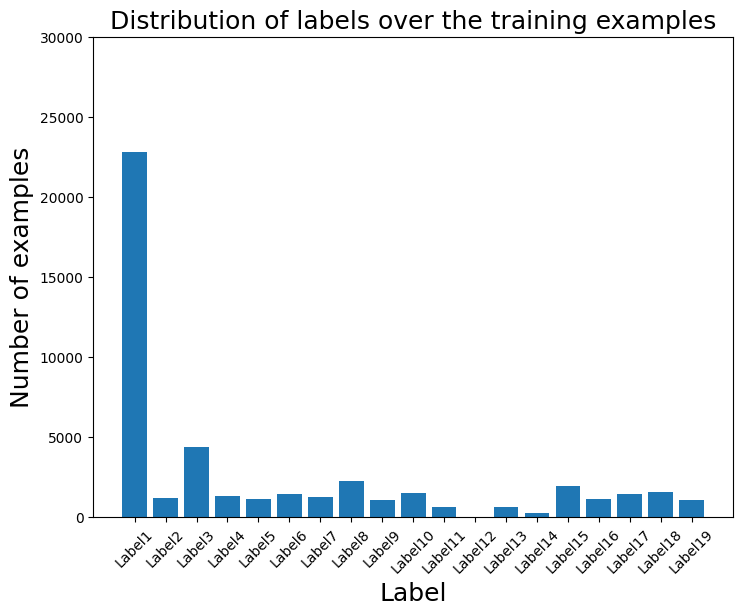

In [ ]:
# Count the number of occurances for each label
list_of_labels = []
list_of_values = []
for i in list(range(1,20)):
    list_of_labels.append("Label"+str(i))
    list_of_values.append(df["Label"+str(i)].sum())
# Plot the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list_of_labels, list_of_values)
plt.xticks(rotation = 45)
plt.title("Distribution of labels over the training examples", fontsize=18)
plt.xlabel("Label", fontsize=18)
plt.ylabel("Number of examples", fontsize=18)
plt.ylim(0, 30000)
plt.show()

<ipython-input-59-20e5b8ceea15>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


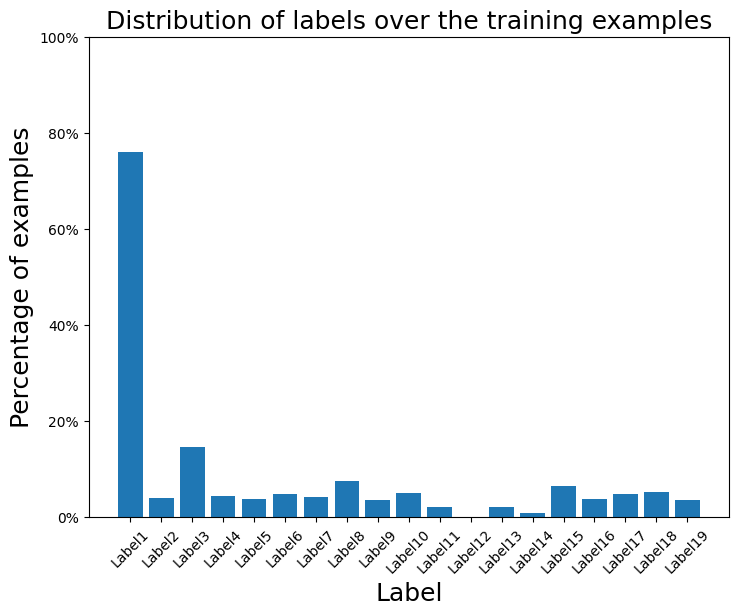

In [ ]:
# Plot the results with a relative y-axis
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list_of_labels, [x/df.shape[0] for x in list_of_values])
plt.xticks(rotation = 45)
plt.title("Distribution of labels over the training examples", fontsize=18)
plt.xlabel("Label", fontsize=18)
plt.ylabel("Percentage of examples", fontsize=18)
plt.ylim(0, 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

In [ ]:
# Here are the absolute number of occurances of each label
print([round(x/df.shape[0]*100,2) for x in list_of_values])

[75.99, 3.87, 14.55, 4.24, 3.77, 4.65, 4.07, 7.37, 3.47, 4.9, 2.01, 0.0, 2.02, 0.84, 6.45, 3.66, 4.77, 5.08, 3.4]


In [ ]:
# Here, we find out how many unique combinations of labels exist
li = []
for x in list(df["Labels"].apply(lambda x: set(x.split()))):
    if x in li:
        pass
    else:
        li.append(x)
print("Number of different combos (corrected for order):",len(li))


Number of different combos (corrected for order): 713


Since this is a very large number of unique combinations, it is not tractable to consider each combination a separate class and solve a multi-class classification problem.

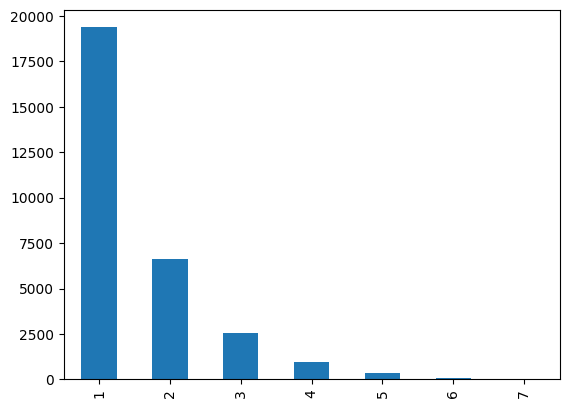

In [ ]:
# Count the number of occurances of the number of labels per example
occ = df["NoLabels"].value_counts()
ax = occ.plot.bar()

In [ ]:
# Print absolute numbers
print(occ)

1    19376
2     6649
3     2563
4      978
5      338
6       81
7       11
Name: NoLabels, dtype: int64


<ipython-input-62-1f0c09affb9b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


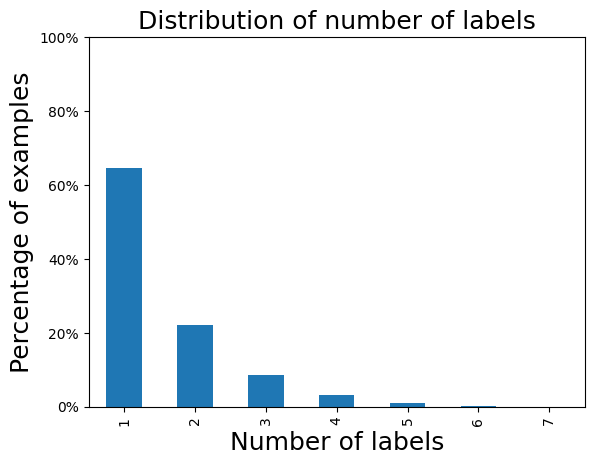

In [ ]:
# Plot relative numbers
df_occ = pd.DataFrame(occ)
df_occ['Freq'] = df_occ['NoLabels'] / df.shape[0]
ax = df_occ['Freq'].plot.bar()
plt.title("Distribution of number of labels", fontsize=18)
plt.xlabel("Number of labels", fontsize=18)
plt.ylabel("Percentage of examples", fontsize=18)
plt.ylim(0, 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

In [ ]:
# Print relative numbers
print([round(x/df.shape[0]*100,2) for x in occ])

[64.6, 22.17, 8.54, 3.26, 1.13, 0.27, 0.04]


## EDA of captions

Text(0, 0.5, 'Number of examples')

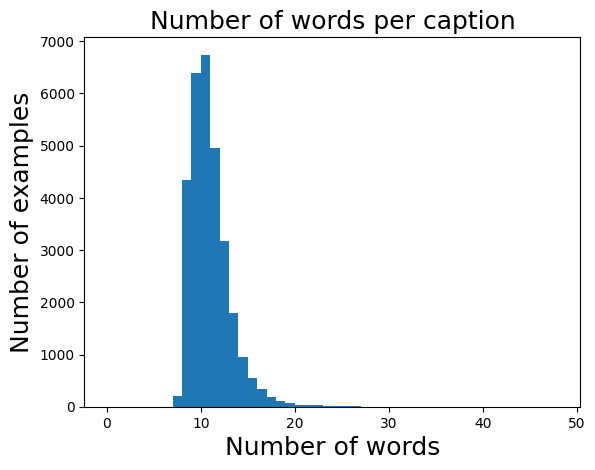

In [ ]:
# Count the number of words per example
lengths = []
for x in range(df.shape[0]):
    length = len(df["Caption"][x].split())
    lengths.append(length)
# Plot results in a histogram
pd.DataFrame(lengths).hist(bins = np.arange(0,max(lengths)), grid=False)
plt.title("Number of words per caption", fontsize=18)
plt.xlabel("Number of words", fontsize=18)
plt.ylabel("Number of examples", fontsize=18)


In [ ]:
# Print max number of words for a single example
max(lengths)

49

## Prepare the captions

In [ ]:
# Helper function that lowercases all words and removes punctuation
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    return text

In [ ]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# Helper function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Stemming
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
# Helper function to stem words
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [ ]:
# Apply the three helper fuctions to the data set
df["Text"] = df["Caption"].apply(clean_text)
df["Text"] = df["Text"].apply(remove_stopwords)
df["Text"] = df["Text"].apply(stemming)
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label11,Label12,Label13,Label14,Label15,Label16,Label17,Label18,Label19,Text
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,woman swim suit hold parasol sunni day
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,coupl men ride hors top green field
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,brave ride jungl eleph
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,black silver clock tower intersect near tree
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,train come stop track side


Text(0, 0.5, 'Number of examples')

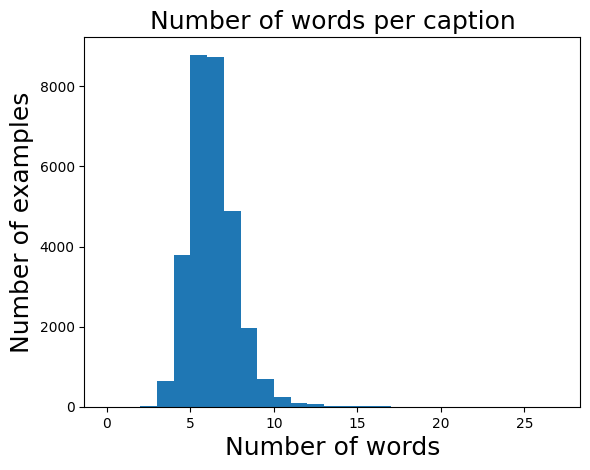

In [ ]:
# Count number of words per example for stemmed data
lengths = []
for x in range(df.shape[0]):
    length = len(df["Text"][x].split())
    lengths.append(length)
# Plot the results in a histogram
pd.DataFrame(lengths).hist(bins = np.arange(0,max(lengths)), grid=False)
plt.title("Number of words per caption", fontsize=18)
plt.xlabel("Number of words", fontsize=18)
plt.ylabel("Number of examples", fontsize=18)


In [ ]:
# Print results
print(pd.DataFrame(lengths).value_counts())

5     8788
6     8734
7     4883
4     3782
8     1967
9      690
3      654
10     244
11     102
12      63
13      27
2       17
14      15
15       8
16       8
17       3
18       3
19       2
23       1
24       1
1        1
22       1
20       1
28       1
dtype: int64


In [ ]:
# Print max length
max(lengths)

28

In [ ]:
# Create a list of unique words
words = []
for i in range(df["Text"].shape[0]):
    new_sentence = [x for x in df["Text"][i].split() if x not in words]
    for new_word in new_sentence:
        if new_word not in words:
            words.append(new_word)

In [ ]:
print(len(words))
print(words[:20])

4791
['woman', 'swim', 'suit', 'hold', 'parasol', 'sunni', 'day', 'coupl', 'men', 'ride', 'hors', 'top', 'green', 'field', 'brave', 'jungl', 'eleph', 'black', 'silver', 'clock']


In [ ]:
# Add two new elements to the list:
# One for padding, one for out-of-vocabulary words
words = ['--PAD--', '--OOV--']+words
print(len(words))
print(words[:20])

4793
['--PAD--', '--OOV--', 'woman', 'swim', 'suit', 'hold', 'parasol', 'sunni', 'day', 'coupl', 'men', 'ride', 'hors', 'top', 'green', 'field', 'brave', 'jungl', 'eleph', 'black']


In [ ]:
# make a dictionary so that we can reference the index of each unique word
word_dict = {w: i for i, w in enumerate(words)}

In [ ]:
# Function to translate words into their dictionary equivalents
def word_to_no(text):
    word_li = text.split()
    no_li = [word_dict[x] if x in word_dict else word_dict['--OOV--'] for x in word_li]
    return no_li
# Create a new column in the dataframe for the translated text
df["NoText"] = df["Text"].apply(lambda x: word_to_no(x))
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label12,Label13,Label14,Label15,Label16,Label17,Label18,Label19,Text,NoText
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,0,0,0,0,woman swim suit hold parasol sunni day,"[2, 3, 4, 5, 6, 7, 8]"
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,0,0,0,0,1,coupl men ride hors top green field,"[9, 10, 11, 12, 13, 14, 15]"
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,brave ride jungl eleph,"[16, 11, 17, 18]"
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,0,1,0,0,0,0,0,0,black silver clock tower intersect near tree,"[19, 20, 21, 22, 23, 24, 25]"
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,0,0,0,0,train come stop track side,"[26, 27, 28, 29, 30]"


In [ ]:
# Pad vectors and cut off at 20th element
max_length = max(lengths)
df["PaddedNoText"] = df["NoText"].apply(lambda x: list(x+[0]*(max_length-len(x)))[:20])
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label13,Label14,Label15,Label16,Label17,Label18,Label19,Text,NoText,PaddedNoText
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,0,0,0,woman swim suit hold parasol sunni day,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,0,0,0,1,coupl men ride hors top green field,"[9, 10, 11, 12, 13, 14, 15]","[9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0, 0, 0, ..."
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,0,0,0,brave ride jungl eleph,"[16, 11, 17, 18]","[16, 11, 17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,1,0,0,0,0,0,0,black silver clock tower intersect near tree,"[19, 20, 21, 22, 23, 24, 25]","[19, 20, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,..."
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,0,0,0,train come stop track side,"[26, 27, 28, 29, 30]","[26, 27, 28, 29, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


# 2. LSTM model for multiple labels

## Prep the data

In [ ]:
# Model input
train_sentences_encoded = []
for x in range(df.shape[0]):
    train_sentences_encoded.append(list(df["PaddedNoText"][x]))
train_sentences_encoded = np.array(train_sentences_encoded)
print(train_sentences_encoded.shape)

(29996, 20)


In [ ]:
# Model output
train_labels = []
for x in range(df.shape[0]):
    train_labels.append([df["Label1"][x], 
                         df["Label2"][x], 
                         df["Label3"][x],
                         df["Label4"][x],
                         df["Label5"][x],
                         df["Label6"][x],
                         df["Label7"][x],
                         df["Label8"][x],
                         df["Label9"][x],
                         df["Label10"][x],
                         df["Label11"][x],
                         df["Label13"][x],
                         df["Label14"][x],
                         df["Label15"][x],
                         df["Label16"][x],
                         df["Label17"][x],
                         df["Label18"][x],
                         df["Label19"][x]
                         ])
train_labels = np.array(train_labels)
print(train_labels.shape)

(29996, 18)


In [ ]:
# Create a validation set
X_train, X_test, y_train, y_test = train_test_split(train_sentences_encoded, 
                                                    train_labels, 
                                                    test_size=0.1, # 10% test, 90% train
                                                    random_state=42)

In [ ]:
print("Training examples:",len(X_train))
print("Testing examples:",len(X_test))

Training examples: 26996
Testing examples: 3000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Use the GPU resources of Google Colab if possible
if gpu_info.find('failed') >= 0:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = 'cpu'

In [ ]:
# If the previous cell gives an error, run this instead
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Transform numpy arrays into tensor
x_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
x_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

In [ ]:
from torch.utils.data import TensorDataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_data, shuffle=True)

## Define and train the model

In [ ]:
# Define the LSTM network

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMClassifier, self).__init__()
        # Word embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=False)  
        # Linear layer: One for each label
        self.lbl1 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl2 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl3 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl4 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl5 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl6 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl7 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl8 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl9 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl10 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl11 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl13 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl14 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl15 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl16 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl17 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl18 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl19 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )


    def forward(self, sentence):
        # Create the word embeddings
        embeds = self.word_embeddings(sentence)
        # Pass it through the LSTM
        lstm_out, _ = self.lstm(embeds)      
        # Add a linear layer
        class_pred_lbl1 = torch.sigmoid(torch.squeeze(self.lbl1(lstm_out), 2))[:,-1]
        class_pred_lbl2 = torch.sigmoid(torch.squeeze(self.lbl2(lstm_out), 2))[:,-1]
        class_pred_lbl3 = torch.sigmoid(torch.squeeze(self.lbl3(lstm_out), 2))[:,-1]
        class_pred_lbl4 = torch.sigmoid(torch.squeeze(self.lbl4(lstm_out), 2))[:,-1]
        class_pred_lbl5 = torch.sigmoid(torch.squeeze(self.lbl5(lstm_out), 2))[:,-1]
        class_pred_lbl6 = torch.sigmoid(torch.squeeze(self.lbl6(lstm_out), 2))[:,-1]
        class_pred_lbl7 = torch.sigmoid(torch.squeeze(self.lbl7(lstm_out), 2))[:,-1]
        class_pred_lbl8 = torch.sigmoid(torch.squeeze(self.lbl8(lstm_out), 2))[:,-1]
        class_pred_lbl9 = torch.sigmoid(torch.squeeze(self.lbl9(lstm_out), 2))[:,-1]
        class_pred_lbl10 = torch.sigmoid(torch.squeeze(self.lbl10(lstm_out), 2))[:,-1]
        class_pred_lbl11 = torch.sigmoid(torch.squeeze(self.lbl11(lstm_out), 2))[:,-1]
        class_pred_lbl13 = torch.sigmoid(torch.squeeze(self.lbl13(lstm_out), 2))[:,-1]
        class_pred_lbl14 = torch.sigmoid(torch.squeeze(self.lbl14(lstm_out), 2))[:,-1]
        class_pred_lbl15 = torch.sigmoid(torch.squeeze(self.lbl15(lstm_out), 2))[:,-1]
        class_pred_lbl16 = torch.sigmoid(torch.squeeze(self.lbl16(lstm_out), 2))[:,-1]
        class_pred_lbl17 = torch.sigmoid(torch.squeeze(self.lbl17(lstm_out), 2))[:,-1]
        class_pred_lbl18 = torch.sigmoid(torch.squeeze(self.lbl18(lstm_out), 2))[:,-1]
        class_pred_lbl19 = torch.sigmoid(torch.squeeze(self.lbl19(lstm_out), 2))[:,-1]
        return {'label1': class_pred_lbl1,
                'label2': class_pred_lbl2,
                'label3': class_pred_lbl3,
                'label4': class_pred_lbl4,
                'label5': class_pred_lbl5,
                'label6': class_pred_lbl6,
                'label7': class_pred_lbl7,
                'label8': class_pred_lbl8,
                'label9': class_pred_lbl9,
                'label10': class_pred_lbl10,
                'label11': class_pred_lbl11,
                'label13': class_pred_lbl13,
                'label14': class_pred_lbl14,
                'label15': class_pred_lbl15,
                'label16': class_pred_lbl16,
                'label17': class_pred_lbl17,
                'label18': class_pred_lbl18,
                'label19': class_pred_lbl19
                }

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from sklearn.metrics import accuracy_score
import time

def criterion(loss_func, outputs, targets):
    losses = 0
    for i, key in enumerate(outputs):
        losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
    return losses

number_epochs = 200

start_time = time.time()

for epoch in range(number_epochs):  
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        model.train()
        optimizer.zero_grad()               
        class_pred = model(sentence)
        loss = criterion(loss_function, class_pred, targets)
        loss.backward()
        optimizer.step()
        loss_now += loss.item() * temp_batch_size
        
        class_pred_tensor = None
        for i, key in enumerate(class_pred.keys()):
            if i==0:
                class_pred_tensor = class_pred[key]
            else:
                all_entries = []
                for i in range(class_pred_tensor.shape[0]):
                    l = class_pred_tensor[i].tolist()
                    if isinstance(l, float):
                        l = [l, class_pred[key][i].item()]
                    else:
                        l.append(class_pred[key][i].item())
                    all_entries.append(l)
                class_pred_tensor = torch.tensor(all_entries)

        pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(pred.detach().numpy(),
                                  targets.detach().numpy())*temp_batch_size
        
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

end_time = time.time() - start_time
print(end_time)

Epoch: 1, training loss: 962.3338, training accuracy: 0.00%
Epoch: 2, training loss: 962.6963, training accuracy: 0.00%
Epoch: 3, training loss: 962.3605, training accuracy: 0.00%
Epoch: 4, training loss: 962.4617, training accuracy: 0.00%
Epoch: 5, training loss: 944.2701, training accuracy: 0.00%
Epoch: 6, training loss: 929.9877, training accuracy: 0.30%
Epoch: 7, training loss: 916.4051, training accuracy: 1.04%
Epoch: 8, training loss: 908.6270, training accuracy: 11.24%
Epoch: 9, training loss: 903.3514, training accuracy: 41.82%
Epoch: 10, training loss: 901.0843, training accuracy: 41.14%
Epoch: 11, training loss: 899.3826, training accuracy: 42.00%
Epoch: 12, training loss: 898.3193, training accuracy: 40.91%
Epoch: 13, training loss: 897.2405, training accuracy: 41.01%
Epoch: 14, training loss: 896.4776, training accuracy: 41.07%
Epoch: 15, training loss: 895.3894, training accuracy: 40.15%
Epoch: 16, training loss: 894.8251, training accuracy: 41.04%
Epoch: 17, training loss

In [ ]:
# torch.save(model, "/content/gdrive/MyDrive/deep_learning_assignment2/LSTM_all_labels_200epochs_all_data_v3.pt")

## Test on test data

In [ ]:
for i in range(1,20):
  if i==12:
    continue
  exec('label'+str(i)+'_actual_class=[]')
  exec('label'+str(i)+'_predicted_class=[]')

for sentence, targets in test_loader:
    # Sentence to classify
    sentence = sentence.to(device)
    # Target class
    target = targets.to(device)
    target = target.view(-1)
    # Predicted class
    prob_pred = model(sentence)
    class_pred_tensor = None
    for i, key in enumerate(prob_pred.keys()):
        if i==0:
            class_pred_tensor = prob_pred[key]
        else:
            all_entries = []
            for i in range(class_pred_tensor.shape[0]):
                l = class_pred_tensor[i].tolist()
                if isinstance(l, float):
                    l = [l, prob_pred[key][i].item()]
                else:
                    l.append(prob_pred[key][i].item())
                all_entries.append(l)
            class_pred_tensor = torch.tensor(all_entries)
    class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

    for i in range(1,20):
      corr=0
      if i==12:
        continue
      if i>12:
        corr=1
      exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
      exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
      exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
      exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

for i in range(1,20):
  if i==12:
    continue

  exec('print("-----LABEL '+str(i)+'-----")')
  exec('print("Test Accuracy: %.2f%%"%(accuracy_score(label'+str(i)+'_actual_class, label'+str(i)+'_predicted_class)*100))')
  exec('print("Test F1-score: %.2f%%"%(f1_score(label'+str(i)+'_actual_class, label'+str(i)+'_predicted_class)*100))')
  exec('print(classification_report(label'+str(i)+'_actual_class, label'+str(i)+'_predicted_class))')


-----LABEL 1-----
Test Accuracy: 89.27%
Test F1-score: 92.85%
              precision    recall  f1-score   support

           0       0.73      0.84      0.79       696
           1       0.95      0.91      0.93      2304

    accuracy                           0.89      3000
   macro avg       0.84      0.88      0.86      3000
weighted avg       0.90      0.89      0.90      3000

-----LABEL 2-----
Test Accuracy: 91.13%
Test F1-score: 35.44%
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2881
           1       0.25      0.61      0.35       119

    accuracy                           0.91      3000
   macro avg       0.62      0.77      0.65      3000
weighted avg       0.95      0.91      0.93      3000

-----LABEL 3-----
Test Accuracy: 84.53%
Test F1-score: 50.95%
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      2568
           1       0.47      0.56      0.51       4

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

acc_scores = []
f1_scores = []

for i in range(1,20):
  if i==12:
    continue
  
  exec('label'+str(i)+'_accuracy = accuracy_score(label'+str(i)+'_actual_class, label'+str(i)+'_predicted_class)')
  exec('label'+str(i)+'_f1 = f1_score(label'+str(i)+'_actual_class, label'+str(i)+'_predicted_class)')

  exec('acc_scores.append(label'+str(i)+'_accuracy)')
  exec('f1_scores.append(label'+str(i)+'_f1)')

print('Average accuracy for all labels:',sum(acc_scores) / len(acc_scores))
print('Average F1-score for all labels:',sum(f1_scores) / len(f1_scores))

Average accuracy for all labels: 0.9509814814814815
Average F1-score for all labels: 0.6256771769823607


In [ ]:
predicted_labels = []
for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
                      label2_predicted_class, 
                      label3_predicted_class,
                      label4_predicted_class,
                      label5_predicted_class,
                      label6_predicted_class,
                      label7_predicted_class,
                      label8_predicted_class,
                      label9_predicted_class,
                      label10_predicted_class,
                      label11_predicted_class,
                      label13_predicted_class,
                      label14_predicted_class,
                      label15_predicted_class,
                      label16_predicted_class,
                      label17_predicted_class,
                      label18_predicted_class,
                      label19_predicted_class):
  predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

actual_labels = []
for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
                      label2_actual_class, 
                      label3_actual_class,
                      label4_actual_class,
                      label5_actual_class,
                      label6_actual_class,
                      label7_actual_class,
                      label8_actual_class,
                      label9_actual_class,
                      label10_actual_class,
                      label11_actual_class,
                      label13_actual_class,
                      label14_actual_class,
                      label15_actual_class,
                      label16_actual_class,
                      label17_actual_class,
                      label18_actual_class,
                      label19_actual_class):
  actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

from sklearn.metrics import accuracy_score, f1_score
print('Accuracy:',accuracy_score(predicted_labels, actual_labels))
print('F1-score:',f1_score(predicted_labels, actual_labels,average='micro'))
print('F1-score:',f1_score(predicted_labels, actual_labels,average='macro'))
print('F1-score:',f1_score(predicted_labels, actual_labels,average='weighted'))
print('F1-score:',f1_score(predicted_labels, actual_labels,average='samples'))


Accuracy: 0.5416666666666666
F1-score: 0.7366955137769821
F1-score: 0.6256771769823606
F1-score: 0.7130192185715146
F1-score: 0.8045669904169905


## Predictions on private test set

Data preprocessing

In [ ]:
# Download testing data
FILENAME = os.path.join(cwd,'test.csv')
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [ ]:
test_df.head()

,ImageID,Caption
0,30000.jpg,A little girl waring a krispy kreme hat holdin...
1,30001.jpg,A beautiful young woman holding an orange fris...
2,30002.jpg,A group of people sitting on couch next to a c...
3,30003.jpg,A person on a snowboard rides on the hill.
4,30004.jpg,A man riding a skateboard with a helmet on in ...


In [ ]:
# Remove the ".jpg" in the IDs
test_df["ID"] = test_df["ImageID"].apply(lambda x: x.split('.')[0])
# Reorder the columns
test_df = test_df[['ImageID', 'ID', 'Caption']]

In [ ]:
# Apply text preprocessing
test_df["Text"] = test_df["Caption"].apply(clean_text)
test_df["Text"] = test_df["Text"].apply(remove_stopwords)
test_df["Text"] = test_df["Text"].apply(stemming)
test_df.head()

,ImageID,ID,Caption,Text
0,30000.jpg,30000,A little girl waring a krispy kreme hat holdin...,littl girl ware krispi kreme hat hold box kris...
1,30001.jpg,30001,A beautiful young woman holding an orange fris...,beauti young woman hold orang frisbe
2,30002.jpg,30002,A group of people sitting on couch next to a c...,group peopl sit couch next coffe tabl
3,30003.jpg,30003,A person on a snowboard rides on the hill.,person snowboard ride hill
4,30004.jpg,30004,A man riding a skateboard with a helmet on in ...,man ride skateboard helmet cone


In [ ]:
# Use dictionary to translate the words and then add the padding
test_df["NoText"] = test_df["Text"].apply(lambda x: word_to_no(x))
test_df["PaddedNoText"] = test_df["NoText"].apply(lambda x: list(x+[0]*(max_length-len(x)))[:20])
test_df.head()

,ImageID,ID,Caption,Text,NoText,PaddedNoText
0,30000.jpg,30000,A little girl waring a krispy kreme hat holdin...,littl girl ware krispi kreme hat hold box kris...,"[115, 58, 1981, 1965, 2714, 199, 5, 240, 1965,...","[115, 58, 1981, 1965, 2714, 199, 5, 240, 1965,..."
1,30001.jpg,30001,A beautiful young woman holding an orange fris...,beauti young woman hold orang frisbe,"[98, 31, 2, 5, 106, 107]","[98, 31, 2, 5, 106, 107, 0, 0, 0, 0, 0, 0, 0, ..."
2,30002.jpg,30002,A group of people sitting on couch next to a c...,group peopl sit couch next coffe tabl,"[245, 64, 57, 235, 50, 61, 63]","[245, 64, 57, 235, 50, 61, 63, 0, 0, 0, 0, 0, ..."
3,30003.jpg,30003,A person on a snowboard rides on the hill.,person snowboard ride hill,"[136, 79, 11, 558]","[136, 79, 11, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,30004.jpg,30004,A man riding a skateboard with a helmet on in ...,man ride skateboard helmet cone,"[32, 11, 33, 284, 638]","[32, 11, 33, 284, 638, 0, 0, 0, 0, 0, 0, 0, 0,..."


Make the predictions

In [ ]:
test_sentences_encoded = []
for x in range(test_df.shape[0]):
    test_sentences_encoded.append(list(test_df["PaddedNoText"][x]))
test_sentences_encoded = np.array(test_sentences_encoded)
test_sentences_encoded.shape

(10000, 20)

In [ ]:
test_tensor = torch.from_numpy(test_sentences_encoded)

In [ ]:
# Use GPU resources if possible
if gpu_info.find('failed') >= 0:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = 'cpu'

In [ ]:
# If the previous cell gives an error, run this instead
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import TensorDataset
test_data = TensorDataset(test_tensor)

from torch.utils.data import DataLoader
test_dataloader = DataLoader(dataset=test_data)

In [ ]:
for i in range(1,20):
  if i==12:
    continue
  exec('label'+str(i)+'_probability = []')
  exec('label'+str(i)+'_predicted_class = []')

import time
start_time = time.time()

for sentence in test_dataloader:
    # Sentence to classify
    sentence = sentence[0]
    sentence = sentence.to(device)
    # Predicted class
    prob_pred = model(sentence)
    class_pred_tensor = None
    for i, key in enumerate(prob_pred.keys()):
        if i==0:
            class_pred_tensor = prob_pred[key]
        else:
            all_entries = []
            for i in range(class_pred_tensor.shape[0]):
                l = class_pred_tensor[i].tolist()
                if isinstance(l, float):
                    l = [l, prob_pred[key][i].item()]
                else:
                    l.append(prob_pred[key][i].item())
                all_entries.append(l)
            class_pred_tensor = torch.tensor(all_entries)
    class_prob = class_pred_tensor.detach().clone()
    class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

    for i in range(1,20):
      if i==12:
        continue
      if i<12:
        num = i-1
      else:
        num = i-2
      exec('label'+str(i)+'_predicted_class.append(int(class_pred[0]['+str(num)+']))')
      exec('label'+str(i)+'_probability.append(float(class_prob[0]['+str(num)+']))')

end_time = time.time() - start_time
print(end_time)

89.30806112289429


In [ ]:
probabilities = []
for i in range(1, 20):
  if i==12:
    continue
  exec('probabilities.append(label'+str(i)+'_probability)')

In [ ]:
# import pickle
# with open("/content/gdrive/MyDrive/deep_learning_assignment2/probabilities_vanilla_all_datav3", "wb") as fp:   #Pickling
#   pickle.dump(probabilities, fp)
 

In [ ]:
labels = []
for i in range(len(label1_predicted_class)):
  labels_for_sent_i = []
  if label1_predicted_class[i] == 1:
    labels_for_sent_i.append(1)
  if label2_predicted_class[i] == 1:
    labels_for_sent_i.append(2)
  if label3_predicted_class[i] == 1:
    labels_for_sent_i.append(3)
  if label4_predicted_class[i] == 1:
    labels_for_sent_i.append(4)
  if label5_predicted_class[i] == 1:
    labels_for_sent_i.append(5)
  if label6_predicted_class[i] == 1:
    labels_for_sent_i.append(6)
  if label7_predicted_class[i] == 1:
    labels_for_sent_i.append(7)
  if label8_predicted_class[i] == 1:
    labels_for_sent_i.append(8)
  if label9_predicted_class[i] == 1:
    labels_for_sent_i.append(9)
  if label10_predicted_class[i] == 1:
    labels_for_sent_i.append(10)
  if label11_predicted_class[i] == 1:
    labels_for_sent_i.append(11)
  if label13_predicted_class[i] == 1:
    labels_for_sent_i.append(13)
  if label14_predicted_class[i] == 1:
    labels_for_sent_i.append(14)
  if label15_predicted_class[i] == 1:
    labels_for_sent_i.append(15)
  if label16_predicted_class[i] == 1:
    labels_for_sent_i.append(16)
  if label17_predicted_class[i] == 1:
    labels_for_sent_i.append(17)
  if label18_predicted_class[i] == 1:
    labels_for_sent_i.append(18)
  if label19_predicted_class[i] == 1:
    labels_for_sent_i.append(19)
  if len(labels_for_sent_i) == 0:
    labels_for_sent_i.append(1)
  labels.append(labels_for_sent_i)


In [ ]:
label_in_correct_format = []
for i in range(len(labels)):
  st = ''
  for x in labels[i]:
    st += str(x) + ' '
  st.strip()
  label_in_correct_format.append(st)

In [ ]:
test_df["Labels"] = pd.DataFrame(label_in_correct_format)

In [ ]:
submission = test_df[["ImageID","Labels"]]
submission

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,2 3 4 6 8 11 13 14
9997,39997.jpg,1
9998,39998.jpg,1


In [ ]:
# submission.to_csv("/content/gdrive/MyDrive/deep_learning_assignment2/vanilla200_all_datav3.csv", index=False)

# 3. Experiments

## Model architecture

In [ ]:
train_sentences_encoded = []
for x in range(df.shape[0]):
    train_sentences_encoded.append(list(df["PaddedNoText"][x]))
train_sentences_encoded = np.array(train_sentences_encoded)

In [ ]:
train_labels = []
for x in range(df.shape[0]):
    train_labels.append([df["Label1"][x], 
                         df["Label2"][x], 
                         df["Label3"][x],
                         df["Label4"][x],
                         df["Label5"][x],
                         df["Label6"][x],
                         df["Label7"][x],
                         df["Label8"][x],
                         df["Label9"][x],
                         df["Label10"][x],
                         df["Label11"][x],
                         df["Label13"][x],
                         df["Label14"][x],
                         df["Label15"][x],
                         df["Label16"][x],
                         df["Label17"][x],
                         df["Label18"][x],
                         df["Label19"][x]
                         ])
train_labels = np.array(train_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_sentences_encoded, 
                                                    train_labels, 
                                                    test_size=0.1, # 10% test, 90% train
                                                    random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if gpu_info.find('failed') >= 0:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = 'cpu'

In [ ]:
import torch
import torch.nn as nn
# Transform numpy arrays into tensor
x_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
x_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

In [ ]:
from torch.utils.data import TensorDataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_data, shuffle=True)

In [ ]:
import torch.nn as nn

class LSTMClassifier_vanilla(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMClassifier_vanilla, self).__init__()
        # Word embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=False)  
        # Linear layer
        self.lbl1 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl2 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl3 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl4 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl5 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl6 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl7 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl8 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl9 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl10 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl11 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl13 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl14 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl15 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl16 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl17 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl18 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl19 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )


    def forward(self, sentence):
        # Create the word embeddings
        embeds = self.word_embeddings(sentence)
        # Pass it through the LSTM
        lstm_out, _ = self.lstm(embeds)      
        # Add a linear layer
        class_pred_lbl1 = torch.sigmoid(torch.squeeze(self.lbl1(lstm_out), 2))[:,-1]
        class_pred_lbl2 = torch.sigmoid(torch.squeeze(self.lbl2(lstm_out), 2))[:,-1]
        class_pred_lbl3 = torch.sigmoid(torch.squeeze(self.lbl3(lstm_out), 2))[:,-1]
        class_pred_lbl4 = torch.sigmoid(torch.squeeze(self.lbl4(lstm_out), 2))[:,-1]
        class_pred_lbl5 = torch.sigmoid(torch.squeeze(self.lbl5(lstm_out), 2))[:,-1]
        class_pred_lbl6 = torch.sigmoid(torch.squeeze(self.lbl6(lstm_out), 2))[:,-1]
        class_pred_lbl7 = torch.sigmoid(torch.squeeze(self.lbl7(lstm_out), 2))[:,-1]
        class_pred_lbl8 = torch.sigmoid(torch.squeeze(self.lbl8(lstm_out), 2))[:,-1]
        class_pred_lbl9 = torch.sigmoid(torch.squeeze(self.lbl9(lstm_out), 2))[:,-1]
        class_pred_lbl10 = torch.sigmoid(torch.squeeze(self.lbl10(lstm_out), 2))[:,-1]
        class_pred_lbl11 = torch.sigmoid(torch.squeeze(self.lbl11(lstm_out), 2))[:,-1]
        class_pred_lbl13 = torch.sigmoid(torch.squeeze(self.lbl13(lstm_out), 2))[:,-1]
        class_pred_lbl14 = torch.sigmoid(torch.squeeze(self.lbl14(lstm_out), 2))[:,-1]
        class_pred_lbl15 = torch.sigmoid(torch.squeeze(self.lbl15(lstm_out), 2))[:,-1]
        class_pred_lbl16 = torch.sigmoid(torch.squeeze(self.lbl16(lstm_out), 2))[:,-1]
        class_pred_lbl17 = torch.sigmoid(torch.squeeze(self.lbl17(lstm_out), 2))[:,-1]
        class_pred_lbl18 = torch.sigmoid(torch.squeeze(self.lbl18(lstm_out), 2))[:,-1]
        class_pred_lbl19 = torch.sigmoid(torch.squeeze(self.lbl19(lstm_out), 2))[:,-1]
        return {'label1': class_pred_lbl1,
                'label2': class_pred_lbl2,
                'label3': class_pred_lbl3,
                'label4': class_pred_lbl4,
                'label5': class_pred_lbl5,
                'label6': class_pred_lbl6,
                'label7': class_pred_lbl7,
                'label8': class_pred_lbl8,
                'label9': class_pred_lbl9,
                'label10': class_pred_lbl10,
                'label11': class_pred_lbl11,
                'label13': class_pred_lbl13,
                'label14': class_pred_lbl14,
                'label15': class_pred_lbl15,
                'label16': class_pred_lbl16,
                'label17': class_pred_lbl17,
                'label18': class_pred_lbl18,
                'label19': class_pred_lbl19
                }



In [ ]:
import torch.nn as nn

class LSTMClassifier_bilstm(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMClassifier_bilstm, self).__init__()
        # Word embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)  
        # Linear layer
        self.lbl1 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl2 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl3 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl4 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl5 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl6 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl7 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl8 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl9 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl10 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl11 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl13 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl14 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl15 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl16 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl17 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl18 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )
        self.lbl19 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=2*hidden_dim, out_features=1)
        )


    def forward(self, sentence):
        # Create the word embeddings
        embeds = self.word_embeddings(sentence)
        # Pass it through the LSTM
        lstm_out, _ = self.lstm(embeds)       
        # Add a linear layer
        class_pred_lbl1 = torch.sigmoid(torch.squeeze(self.lbl1(lstm_out), 2))[:,-1]
        class_pred_lbl2 = torch.sigmoid(torch.squeeze(self.lbl2(lstm_out), 2))[:,-1]
        class_pred_lbl3 = torch.sigmoid(torch.squeeze(self.lbl3(lstm_out), 2))[:,-1]
        class_pred_lbl4 = torch.sigmoid(torch.squeeze(self.lbl4(lstm_out), 2))[:,-1]
        class_pred_lbl5 = torch.sigmoid(torch.squeeze(self.lbl5(lstm_out), 2))[:,-1]
        class_pred_lbl6 = torch.sigmoid(torch.squeeze(self.lbl6(lstm_out), 2))[:,-1]
        class_pred_lbl7 = torch.sigmoid(torch.squeeze(self.lbl7(lstm_out), 2))[:,-1]
        class_pred_lbl8 = torch.sigmoid(torch.squeeze(self.lbl8(lstm_out), 2))[:,-1]
        class_pred_lbl9 = torch.sigmoid(torch.squeeze(self.lbl9(lstm_out), 2))[:,-1]
        class_pred_lbl10 = torch.sigmoid(torch.squeeze(self.lbl10(lstm_out), 2))[:,-1]
        class_pred_lbl11 = torch.sigmoid(torch.squeeze(self.lbl11(lstm_out), 2))[:,-1]
        class_pred_lbl13 = torch.sigmoid(torch.squeeze(self.lbl13(lstm_out), 2))[:,-1]
        class_pred_lbl14 = torch.sigmoid(torch.squeeze(self.lbl14(lstm_out), 2))[:,-1]
        class_pred_lbl15 = torch.sigmoid(torch.squeeze(self.lbl15(lstm_out), 2))[:,-1]
        class_pred_lbl16 = torch.sigmoid(torch.squeeze(self.lbl16(lstm_out), 2))[:,-1]
        class_pred_lbl17 = torch.sigmoid(torch.squeeze(self.lbl17(lstm_out), 2))[:,-1]
        class_pred_lbl18 = torch.sigmoid(torch.squeeze(self.lbl18(lstm_out), 2))[:,-1]
        class_pred_lbl19 = torch.sigmoid(torch.squeeze(self.lbl19(lstm_out), 2))[:,-1]
        return {'label1': class_pred_lbl1,
                'label2': class_pred_lbl2,
                'label3': class_pred_lbl3,
                'label4': class_pred_lbl4,
                'label5': class_pred_lbl5,
                'label6': class_pred_lbl6,
                'label7': class_pred_lbl7,
                'label8': class_pred_lbl8,
                'label9': class_pred_lbl9,
                'label10': class_pred_lbl10,
                'label11': class_pred_lbl11,
                'label13': class_pred_lbl13,
                'label14': class_pred_lbl14,
                'label15': class_pred_lbl15,
                'label16': class_pred_lbl16,
                'label17': class_pred_lbl17,
                'label18': class_pred_lbl18,
                'label19': class_pred_lbl19
                }



In [ ]:
import torch.nn as nn

class LSTMClassifier_twolayers(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMClassifier_twolayers, self).__init__()
        # Word embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=False)  
        self.lstm2 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=False)
        )
        # Linear layer
        self.lbl1 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl2 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl3 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl4 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl5 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl6 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl7 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl8 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl9 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl10 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl11 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl13 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl14 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl15 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl16 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl17 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl18 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl19 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )


    def forward(self, sentence):
        # Create the word embeddings
        embeds = self.word_embeddings(sentence)
        # Pass it through the LSTM
        lstm_out, _ = self.lstm(embeds)
        # Stacked LSTM
        lstm_out, _ = self.lstm2(lstm_out)        
        # Add a linear layer
        class_pred_lbl1 = torch.sigmoid(torch.squeeze(self.lbl1(lstm_out), 2))[:,-1]
        class_pred_lbl2 = torch.sigmoid(torch.squeeze(self.lbl2(lstm_out), 2))[:,-1]
        class_pred_lbl3 = torch.sigmoid(torch.squeeze(self.lbl3(lstm_out), 2))[:,-1]
        class_pred_lbl4 = torch.sigmoid(torch.squeeze(self.lbl4(lstm_out), 2))[:,-1]
        class_pred_lbl5 = torch.sigmoid(torch.squeeze(self.lbl5(lstm_out), 2))[:,-1]
        class_pred_lbl6 = torch.sigmoid(torch.squeeze(self.lbl6(lstm_out), 2))[:,-1]
        class_pred_lbl7 = torch.sigmoid(torch.squeeze(self.lbl7(lstm_out), 2))[:,-1]
        class_pred_lbl8 = torch.sigmoid(torch.squeeze(self.lbl8(lstm_out), 2))[:,-1]
        class_pred_lbl9 = torch.sigmoid(torch.squeeze(self.lbl9(lstm_out), 2))[:,-1]
        class_pred_lbl10 = torch.sigmoid(torch.squeeze(self.lbl10(lstm_out), 2))[:,-1]
        class_pred_lbl11 = torch.sigmoid(torch.squeeze(self.lbl11(lstm_out), 2))[:,-1]
        class_pred_lbl13 = torch.sigmoid(torch.squeeze(self.lbl13(lstm_out), 2))[:,-1]
        class_pred_lbl14 = torch.sigmoid(torch.squeeze(self.lbl14(lstm_out), 2))[:,-1]
        class_pred_lbl15 = torch.sigmoid(torch.squeeze(self.lbl15(lstm_out), 2))[:,-1]
        class_pred_lbl16 = torch.sigmoid(torch.squeeze(self.lbl16(lstm_out), 2))[:,-1]
        class_pred_lbl17 = torch.sigmoid(torch.squeeze(self.lbl17(lstm_out), 2))[:,-1]
        class_pred_lbl18 = torch.sigmoid(torch.squeeze(self.lbl18(lstm_out), 2))[:,-1]
        class_pred_lbl19 = torch.sigmoid(torch.squeeze(self.lbl19(lstm_out), 2))[:,-1]
        return {'label1': class_pred_lbl1,
                'label2': class_pred_lbl2,
                'label3': class_pred_lbl3,
                'label4': class_pred_lbl4,
                'label5': class_pred_lbl5,
                'label6': class_pred_lbl6,
                'label7': class_pred_lbl7,
                'label8': class_pred_lbl8,
                'label9': class_pred_lbl9,
                'label10': class_pred_lbl10,
                'label11': class_pred_lbl11,
                'label13': class_pred_lbl13,
                'label14': class_pred_lbl14,
                'label15': class_pred_lbl15,
                'label16': class_pred_lbl16,
                'label17': class_pred_lbl17,
                'label18': class_pred_lbl18,
                'label19': class_pred_lbl19
                }


In [ ]:
import time
from sklearn.metrics import accuracy_score, f1_score

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

def criterion(loss_func, outputs, targets):
    losses = 0
    for i, key in enumerate(outputs):
        losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
    return losses

number_epochs = 20

test_accs = []
test_f1ms = []
test_f1ss = []
training_times = []
testing_times = []

for model_type in ['vanilla', 'bilstm', 'twolayers']:

  test_acc = []
  test_f1m = []
  test_f1s = []
  training_time = []
  testing_time = []

  for iterator in range(3):

    print("------STARTING MODEL "+ str(iterator)+" FOR MODEL TYPE "+str(model_type)+"------")

    # INITIALIZE MODEL
    if model_type=='vanilla':
      model = LSTMClassifier_vanilla(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
    elif model_type=='bilstm':
      model = LSTMClassifier_bilstm(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
    elif model_type=='twolayers':
      model = LSTMClassifier_twolayers(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # TRAIN MODEL

    start_training = time.time()

    for epoch in range(number_epochs):

      loss_now = 0.0
      correct = 0

      for sentence,targets in train_loader:
          
          sentence = sentence.to(device)
          targets = targets.to(device)

          temp_batch_size = sentence.shape[0]

          model.train()
          optimizer.zero_grad()               
          class_pred = model(sentence)
          loss = criterion(loss_function, class_pred, targets)
          loss.backward()
          optimizer.step()
          loss_now += loss.item() * temp_batch_size
          
          class_pred_tensor = None

          for i, key in enumerate(class_pred.keys()):
              if i==0:
                  class_pred_tensor = class_pred[key]
              else:
                  all_entries = []
                  for i in range(class_pred_tensor.shape[0]):
                      l = class_pred_tensor[i].tolist()
                      if isinstance(l, float):
                          l = [l, class_pred[key][i].item()]
                      else:
                          l.append(class_pred[key][i].item())
                      all_entries.append(l)
                  class_pred_tensor = torch.tensor(all_entries)

          pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
          correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
        
      print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

    training_time_val = time.time() - start_training

    # TEST MODEL

    start_testing = time.time()

    for i in range(1,20):
      if i==12:
        continue
      exec('label'+str(i)+'_actual_class=[]')
      exec('label'+str(i)+'_predicted_class=[]')

    for sentence, targets in test_loader:
        # Sentence to classify
        sentence = sentence.to(device)
        # Target class
        target = targets.to(device)
        target = target.view(-1)
        # Predicted class
        prob_pred = model(sentence)
        class_pred_tensor = None
        for i, key in enumerate(prob_pred.keys()):
            if i==0:
                class_pred_tensor = prob_pred[key]
            else:
                all_entries = []
                for i in range(class_pred_tensor.shape[0]):
                    l = class_pred_tensor[i].tolist()
                    if isinstance(l, float):
                        l = [l, prob_pred[key][i].item()]
                    else:
                        l.append(prob_pred[key][i].item())
                    all_entries.append(l)
                class_pred_tensor = torch.tensor(all_entries)
        class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

        for i in range(1,20):
          corr=0
          if i==12:
            continue
          if i>12:
            corr=1
          exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
          exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
          exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
          exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

    # CREATE PREDICTION LIST PER LABEL

    predicted_labels = []
    for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
                          label2_predicted_class, 
                          label3_predicted_class,
                          label4_predicted_class,
                          label5_predicted_class,
                          label6_predicted_class,
                          label7_predicted_class,
                          label8_predicted_class,
                          label9_predicted_class,
                          label10_predicted_class,
                          label11_predicted_class,
                          label13_predicted_class,
                          label14_predicted_class,
                          label15_predicted_class,
                          label16_predicted_class,
                          label17_predicted_class,
                          label18_predicted_class,
                          label19_predicted_class):
      predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

    actual_labels = []
    for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
                          label2_actual_class, 
                          label3_actual_class,
                          label4_actual_class,
                          label5_actual_class,
                          label6_actual_class,
                          label7_actual_class,
                          label8_actual_class,
                          label9_actual_class,
                          label10_actual_class,
                          label11_actual_class,
                          label13_actual_class,
                          label14_actual_class,
                          label15_actual_class,
                          label16_actual_class,
                          label17_actual_class,
                          label18_actual_class,
                          label19_actual_class):
      actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

    testing_time_val = time.time() - start_testing

    # CALCULATE PERFORMANCE METRICS

    acc = accuracy_score(predicted_labels, actual_labels)
    f1m = f1_score(predicted_labels, actual_labels,average='micro')
    f1s = f1_score(predicted_labels, actual_labels,average='samples')

    test_acc.append(acc)
    test_f1m.append(f1m)
    test_f1s.append(f1s)
    training_time.append(training_time_val)
    testing_time.append(testing_time_val)

  print("STATS FOR MODEL TYPE "+str(model_type))
  print(test_acc)
  print(test_f1m)
  print(test_f1s)
  print(training_time)
  print(testing_time)
  
  test_accs.append(test_acc)
  test_f1ms.append(test_f1m)
  test_f1ss.append(test_f1s)
  training_times.append(training_time)
  testing_times.append(testing_time)



------STARTING MODEL 0 FOR MODEL TYPE vanilla------
Epoch: 1, training loss: 960.8549, training accuracy: 0.00%
Epoch: 2, training loss: 938.2651, training accuracy: 0.00%
Epoch: 3, training loss: 929.1540, training accuracy: 0.00%
Epoch: 4, training loss: 917.0210, training accuracy: 10.25%
Epoch: 5, training loss: 909.2904, training accuracy: 41.84%
Epoch: 6, training loss: 906.7206, training accuracy: 42.11%
Epoch: 7, training loss: 905.0612, training accuracy: 40.14%
Epoch: 8, training loss: 902.9897, training accuracy: 38.99%
Epoch: 9, training loss: 901.4068, training accuracy: 40.05%
Epoch: 10, training loss: 899.7846, training accuracy: 39.78%
Epoch: 11, training loss: 898.7758, training accuracy: 39.99%
Epoch: 12, training loss: 897.7895, training accuracy: 41.42%
Epoch: 13, training loss: 897.0403, training accuracy: 44.08%
Epoch: 14, training loss: 896.3159, training accuracy: 42.50%
Epoch: 15, training loss: 895.0739, training accuracy: 43.81%
Epoch: 16, training loss: 893.

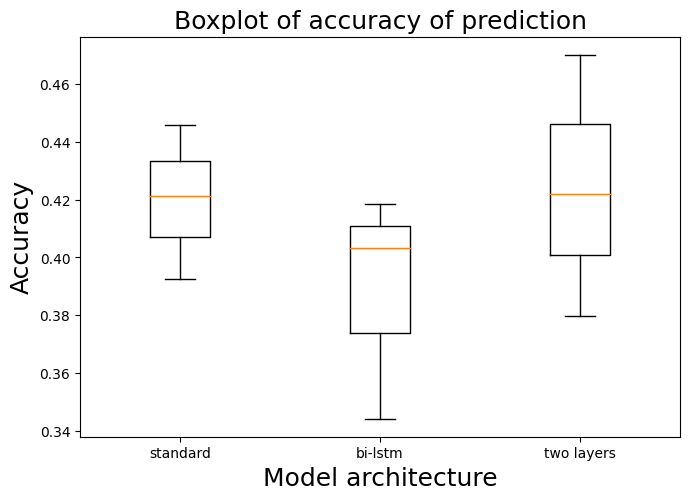

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_accs)
ax.set_xticklabels(['standard', 'bi-lstm', 'two layers'])
plt.title("Boxplot of accuracy of prediction", fontsize=18)
plt.xlabel("Model architecture", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.show()

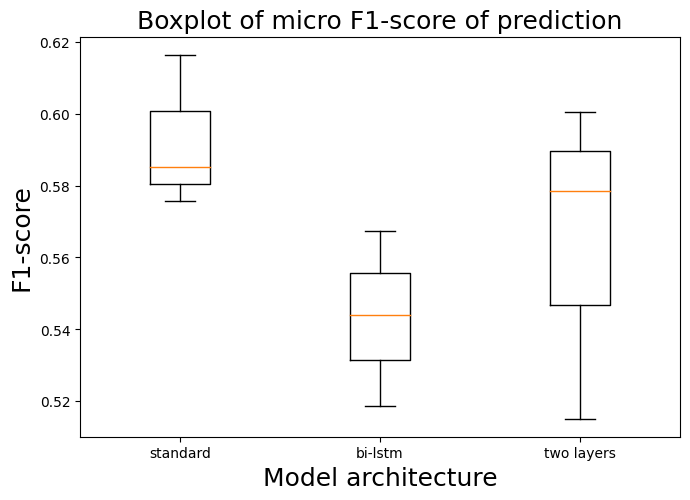

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_f1ms)
ax.set_xticklabels(['standard', 'bi-lstm', 'two layers'])
plt.title("Boxplot of micro F1-score of prediction", fontsize=18)
plt.xlabel("Model architecture", fontsize=18)
plt.ylabel("F1-score", fontsize=18)
plt.show()

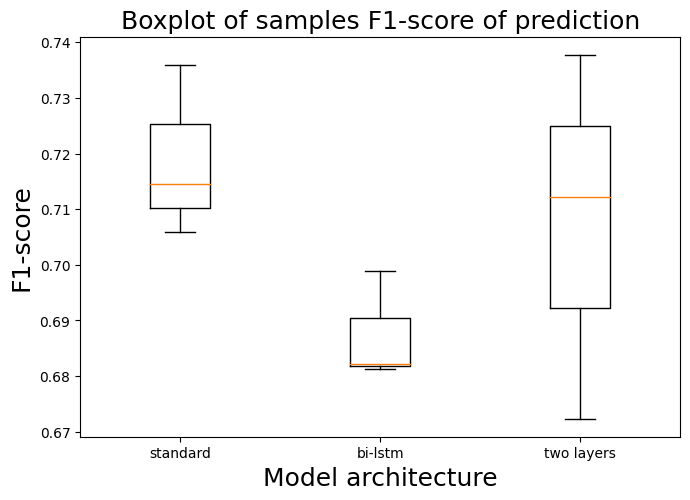

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_f1ss)
ax.set_xticklabels(['standard', 'bi-lstm', 'two layers'])
plt.title("Boxplot of samples F1-score of prediction", fontsize=18)
plt.xlabel("Model architecture", fontsize=18)
plt.ylabel("F1-score", fontsize=18)
plt.show()

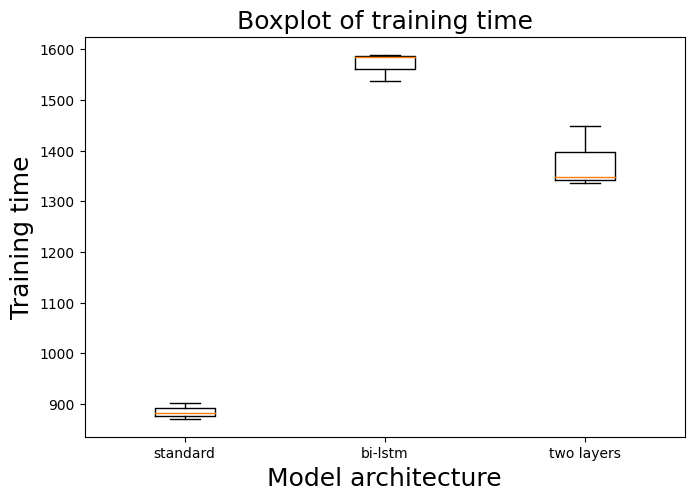

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(training_times)
ax.set_xticklabels(['standard', 'bi-lstm', 'two layers'])
plt.title("Boxplot of training time", fontsize=18)
plt.xlabel("Model architecture", fontsize=18)
plt.ylabel("Training time", fontsize=18)
plt.show()

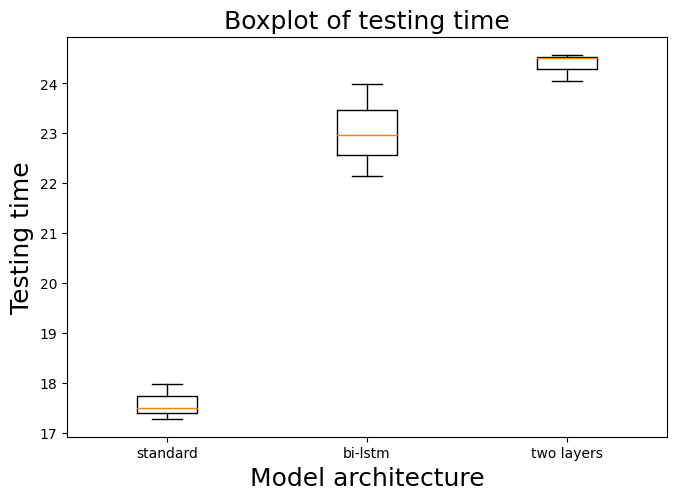

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(testing_times)
ax.set_xticklabels(['standard', 'bi-lstm', 'two layers'])
plt.title("Boxplot of testing time", fontsize=18)
plt.xlabel("Model architecture", fontsize=18)
plt.ylabel("Testing time", fontsize=18)
plt.show()


## Change cut-off value

In [ ]:
import time

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

def criterion(loss_func, outputs, targets):
    losses = 0
    for i, key in enumerate(outputs):
        losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
    return losses

number_epochs = 20

test_accs = []
test_f1ms = []
test_f1ss = []
training_times = []
testing_times = []

for cutoff in [0.25, 0.5, 0.75]:

  test_acc = []
  test_f1m = []
  test_f1s = []
  training_time = []
  testing_time = []

  for iterator in range(3):

    print("------STARTING MODEL "+ str(iterator)+" FOR CUTOFF VALUE "+str(cutoff)+"------")

    # INITIALIZE MODEL

    model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # TRAIN MODEL

    start_training = time.time()

    for epoch in range(number_epochs):

      loss_now = 0.0
      correct = 0

      for sentence,targets in train_loader:
          
          sentence = sentence.to(device)
          targets = targets.to(device)

          temp_batch_size = sentence.shape[0]

          model.train()
          optimizer.zero_grad()               
          class_pred = model(sentence)
          loss = criterion(loss_function, class_pred, targets)
          loss.backward()
          optimizer.step()
          loss_now += loss.item() * temp_batch_size
          
          class_pred_tensor = None

          for i, key in enumerate(class_pred.keys()):
              if i==0:
                  class_pred_tensor = class_pred[key]
              else:
                  all_entries = []
                  for i in range(class_pred_tensor.shape[0]):
                      l = class_pred_tensor[i].tolist()
                      if isinstance(l, float):
                          l = [l, class_pred[key][i].item()]
                      else:
                          l.append(class_pred[key][i].item())
                      all_entries.append(l)
                  class_pred_tensor = torch.tensor(all_entries)

          pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>cutoff else int(0))
          correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
        
      print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

    training_time_val = time.time() - start_training

    # TEST MODEL

    start_testing = time.time()

    for i in range(1,20):
      if i==12:
        continue
      exec('label'+str(i)+'_actual_class=[]')
      exec('label'+str(i)+'_predicted_class=[]')

    for sentence, targets in test_loader:
        # Sentence to classify
        sentence = sentence.to(device)
        # Target class
        target = targets.to(device)
        target = target.view(-1)
        # Predicted class
        prob_pred = model(sentence)
        class_pred_tensor = None
        for i, key in enumerate(prob_pred.keys()):
            if i==0:
                class_pred_tensor = prob_pred[key]
            else:
                all_entries = []
                for i in range(class_pred_tensor.shape[0]):
                    l = class_pred_tensor[i].tolist()
                    if isinstance(l, float):
                        l = [l, prob_pred[key][i].item()]
                    else:
                        l.append(prob_pred[key][i].item())
                    all_entries.append(l)
                class_pred_tensor = torch.tensor(all_entries)
        class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>cutoff else int(0))

        for i in range(1,20):
          corr=0
          if i==12:
            continue
          if i>12:
            corr=1
          exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
          exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
          exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
          exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

    # CREATE PREDICTION LIST PER LABEL

    predicted_labels = []
    for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
                          label2_predicted_class, 
                          label3_predicted_class,
                          label4_predicted_class,
                          label5_predicted_class,
                          label6_predicted_class,
                          label7_predicted_class,
                          label8_predicted_class,
                          label9_predicted_class,
                          label10_predicted_class,
                          label11_predicted_class,
                          label13_predicted_class,
                          label14_predicted_class,
                          label15_predicted_class,
                          label16_predicted_class,
                          label17_predicted_class,
                          label18_predicted_class,
                          label19_predicted_class):
      predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

    actual_labels = []
    for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
                          label2_actual_class, 
                          label3_actual_class,
                          label4_actual_class,
                          label5_actual_class,
                          label6_actual_class,
                          label7_actual_class,
                          label8_actual_class,
                          label9_actual_class,
                          label10_actual_class,
                          label11_actual_class,
                          label13_actual_class,
                          label14_actual_class,
                          label15_actual_class,
                          label16_actual_class,
                          label17_actual_class,
                          label18_actual_class,
                          label19_actual_class):
      actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

    testing_time_val = time.time() - start_testing

    # CALCULATE PERFORMANCE METRICS

    from sklearn.metrics import accuracy_score, f1_score

    acc = accuracy_score(predicted_labels, actual_labels)
    f1m = f1_score(predicted_labels, actual_labels,average='micro')
    f1s = f1_score(predicted_labels, actual_labels,average='samples')

    test_acc.append(acc)
    test_f1m.append(f1m)
    test_f1s.append(f1s)
    training_time.append(training_time_val)
    testing_time.append(testing_time_val)

  print("STATS FOR CUTOFF VALUE "+str(cutoff))
  print(test_acc)
  print(test_f1m)
  print(test_f1s)
  print(training_time)
  print(testing_time)
  
  test_accs.append(test_acc)
  test_f1ms.append(test_f1m)
  test_f1ss.append(test_f1s)
  training_times.append(training_time)
  testing_times.append(testing_time)



------STARTING MODEL 0 FOR CUTOFF VALUE 0.25------
Epoch: 1, training loss: 961.7291, training accuracy: 0.00%
Epoch: 2, training loss: 961.6230, training accuracy: 0.00%
Epoch: 3, training loss: 961.6436, training accuracy: 0.00%
Epoch: 4, training loss: 961.6029, training accuracy: 0.00%
Epoch: 5, training loss: 949.9572, training accuracy: 3.74%
Epoch: 6, training loss: 928.6279, training accuracy: 19.39%
Epoch: 7, training loss: 924.1007, training accuracy: 28.45%
Epoch: 8, training loss: 920.8989, training accuracy: 33.66%
Epoch: 9, training loss: 915.0201, training accuracy: 40.37%
Epoch: 10, training loss: 905.7068, training accuracy: 41.45%
Epoch: 11, training loss: 900.5545, training accuracy: 42.24%
Epoch: 12, training loss: 898.1690, training accuracy: 42.05%
Epoch: 13, training loss: 896.2562, training accuracy: 42.05%
Epoch: 14, training loss: 894.9099, training accuracy: 43.18%
Epoch: 15, training loss: 893.6663, training accuracy: 44.69%
Epoch: 16, training loss: 892.770

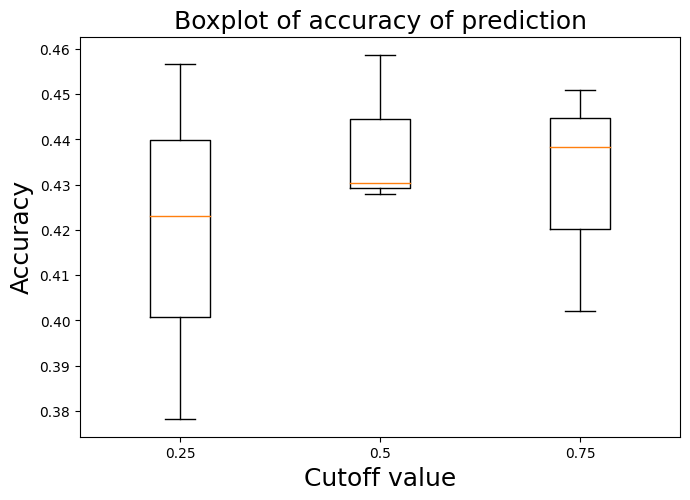

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_accs)
ax.set_xticklabels(['0.25','0.5','0.75'])
plt.title("Boxplot of accuracy of prediction", fontsize=18)
plt.xlabel("Cutoff value", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.show()

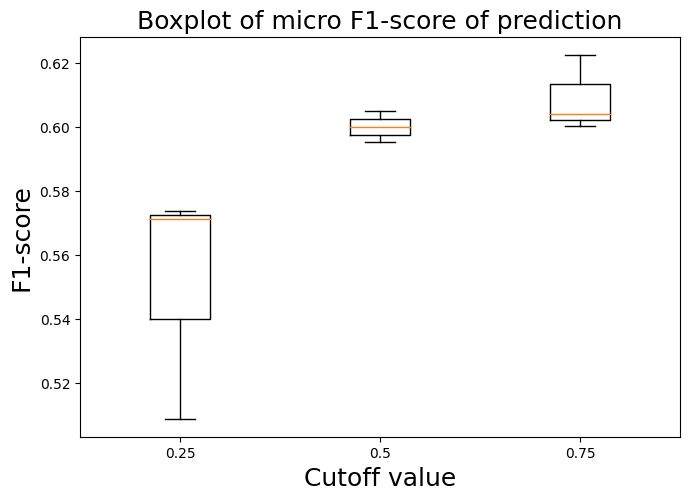

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_f1ms)
ax.set_xticklabels(['0.25','0.5','0.75'])
plt.title("Boxplot of micro F1-score of prediction", fontsize=18)
plt.xlabel("Cutoff value", fontsize=18)
plt.ylabel("F1-score", fontsize=18)
plt.show()

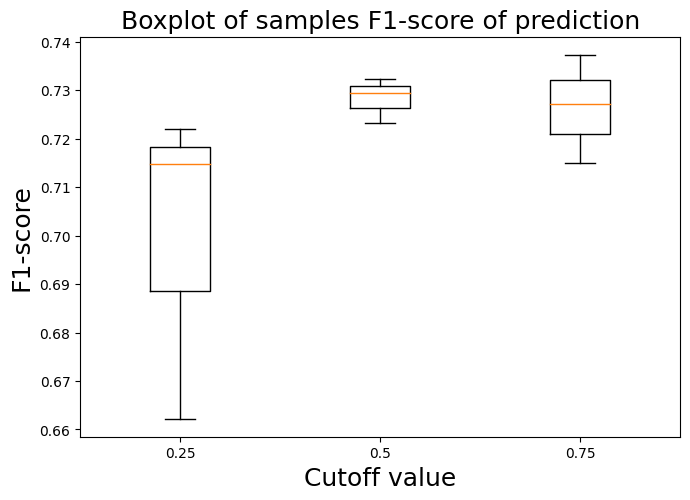

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_f1ss)
ax.set_xticklabels(['0.25','0.5','0.75'])
plt.title("Boxplot of samples F1-score of prediction", fontsize=18)
plt.xlabel("Cutoff value", fontsize=18)
plt.ylabel("F1-score", fontsize=18)
plt.show()

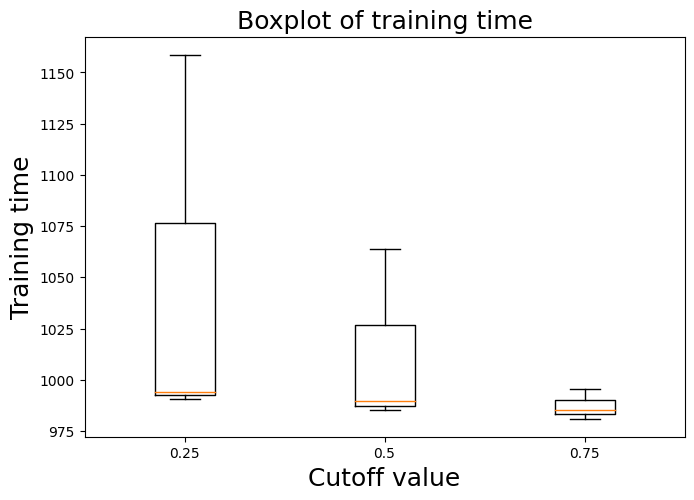

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(training_times)
ax.set_xticklabels(['0.25','0.5','0.75'])
plt.title("Boxplot of training time", fontsize=18)
plt.xlabel("Cutoff value", fontsize=18)
plt.ylabel("Training time", fontsize=18)
plt.show()

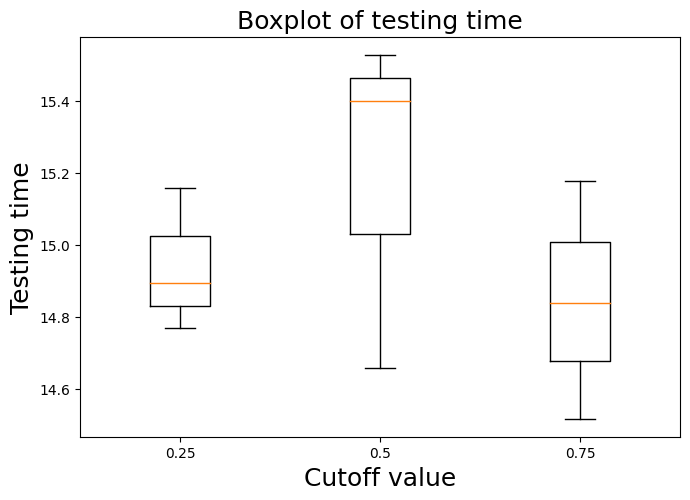

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(testing_times)
ax.set_xticklabels(['0.25','0.5','0.75'])
plt.title("Boxplot of testing time", fontsize=18)
plt.xlabel("Cutoff value", fontsize=18)
plt.ylabel("Testing time", fontsize=18)
plt.show()

## Word Embedding Dimension

In [ ]:
# import time

# HIDDEN_DIM = 256

# def criterion(loss_func, outputs, targets):
#     losses = 0
#     for i, key in enumerate(outputs):
#         losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
#     return losses

# number_epochs = 20

# test_accs = []
# test_f1ms = []
# test_f1ss = []
# training_times = []
# testing_times = []

# for embdim in [32, 64, 128]:

#   test_acc = []
#   test_f1m = []
#   test_f1s = []
#   training_time = []
#   testing_time = []

#   EMBEDDING_DIM = embdim

#   for iterator in range(3):

#     print("------STARTING MODEL "+ str(iterator)+" FOR EMB DIM VALUE "+str(embdim)+"------")

#     # INITIALIZE MODEL

#     model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
#     loss_function = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#     # TRAIN MODEL

#     start_training = time.time()

#     for epoch in range(number_epochs):

#       loss_now = 0.0
#       correct = 0

#       for sentence,targets in train_loader:
          
#           sentence = sentence.to(device)
#           targets = targets.to(device)

#           temp_batch_size = sentence.shape[0]

#           model.train()
#           optimizer.zero_grad()               
#           class_pred = model(sentence)
#           loss = criterion(loss_function, class_pred, targets)
#           loss.backward()
#           optimizer.step()
#           loss_now += loss.item() * temp_batch_size
          
#           class_pred_tensor = None

#           for i, key in enumerate(class_pred.keys()):
#               if i==0:
#                   class_pred_tensor = class_pred[key]
#               else:
#                   all_entries = []
#                   for i in range(class_pred_tensor.shape[0]):
#                       l = class_pred_tensor[i].tolist()
#                       if isinstance(l, float):
#                           l = [l, class_pred[key][i].item()]
#                       else:
#                           l.append(class_pred[key][i].item())
#                       all_entries.append(l)
#                   class_pred_tensor = torch.tensor(all_entries)

#           pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
#           correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
        
#       print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

#     training_time_val = time.time() - start_training

#     # TEST MODEL

#     start_testing = time.time()

#     for i in range(1,20):
#       if i==12:
#         continue
#       exec('label'+str(i)+'_actual_class=[]')
#       exec('label'+str(i)+'_predicted_class=[]')

#     for sentence, targets in test_loader:
#         # Sentence to classify
#         sentence = sentence.to(device)
#         # Target class
#         target = targets.to(device)
#         target = target.view(-1)
#         # Predicted class
#         prob_pred = model(sentence)
#         class_pred_tensor = None
#         for i, key in enumerate(prob_pred.keys()):
#             if i==0:
#                 class_pred_tensor = prob_pred[key]
#             else:
#                 all_entries = []
#                 for i in range(class_pred_tensor.shape[0]):
#                     l = class_pred_tensor[i].tolist()
#                     if isinstance(l, float):
#                         l = [l, prob_pred[key][i].item()]
#                     else:
#                         l.append(prob_pred[key][i].item())
#                     all_entries.append(l)
#                 class_pred_tensor = torch.tensor(all_entries)
#         class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

#         for i in range(1,20):
#           corr=0
#           if i==12:
#             continue
#           if i>12:
#             corr=1
#           exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
#           exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
#           exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
#           exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

#     # CREATE PREDICTION LIST PER LABEL

#     predicted_labels = []
#     for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
#                           label2_predicted_class, 
#                           label3_predicted_class,
#                           label4_predicted_class,
#                           label5_predicted_class,
#                           label6_predicted_class,
#                           label7_predicted_class,
#                           label8_predicted_class,
#                           label9_predicted_class,
#                           label10_predicted_class,
#                           label11_predicted_class,
#                           label13_predicted_class,
#                           label14_predicted_class,
#                           label15_predicted_class,
#                           label16_predicted_class,
#                           label17_predicted_class,
#                           label18_predicted_class,
#                           label19_predicted_class):
#       predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

#     actual_labels = []
#     for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
#                           label2_actual_class, 
#                           label3_actual_class,
#                           label4_actual_class,
#                           label5_actual_class,
#                           label6_actual_class,
#                           label7_actual_class,
#                           label8_actual_class,
#                           label9_actual_class,
#                           label10_actual_class,
#                           label11_actual_class,
#                           label13_actual_class,
#                           label14_actual_class,
#                           label15_actual_class,
#                           label16_actual_class,
#                           label17_actual_class,
#                           label18_actual_class,
#                           label19_actual_class):
#       actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

#     testing_time_val = time.time() - start_testing

#     # CALCULATE PERFORMANCE METRICS

#     from sklearn.metrics import accuracy_score, f1_score

#     acc = accuracy_score(predicted_labels, actual_labels)
#     f1m = f1_score(predicted_labels, actual_labels,average='micro')
#     f1s = f1_score(predicted_labels, actual_labels,average='samples')

#     test_acc.append(acc)
#     test_f1m.append(f1m)
#     test_f1s.append(f1s)
#     training_time.append(training_time_val)
#     testing_time.append(testing_time_val)
  
#   print("STATS FOR EMB DIM VALUE "+str(embdim))
#   print(test_acc)
#   print(test_f1m)
#   print(test_f1s)
#   print(training_time)
#   print(testing_time)

#   test_accs.append(test_acc)
#   test_f1ms.append(test_f1m)
#   test_f1ss.append(test_f1s)
#   training_times.append(training_time)
#   testing_times.append(testing_time)



------STARTING MODEL 0 FOR EMB DIM VALUE 32------
Epoch: 1, training loss: 961.6102, training accuracy: 0.00%
Epoch: 2, training loss: 961.6041, training accuracy: 0.00%
Epoch: 3, training loss: 961.5349, training accuracy: 0.00%
Epoch: 4, training loss: 961.5637, training accuracy: 0.00%
Epoch: 5, training loss: 961.6238, training accuracy: 0.00%
Epoch: 6, training loss: 961.6012, training accuracy: 0.00%
Epoch: 7, training loss: 961.6087, training accuracy: 0.00%
Epoch: 8, training loss: 961.5853, training accuracy: 0.00%
Epoch: 9, training loss: 961.5463, training accuracy: 0.00%
Epoch: 10, training loss: 961.5379, training accuracy: 0.00%
Epoch: 11, training loss: 961.5559, training accuracy: 0.00%
Epoch: 12, training loss: 961.5799, training accuracy: 0.00%
Epoch: 13, training loss: 960.0634, training accuracy: 0.00%
Epoch: 14, training loss: 961.5860, training accuracy: 0.00%
Epoch: 15, training loss: 961.5960, training accuracy: 0.00%
Epoch: 16, training loss: 961.1824, training

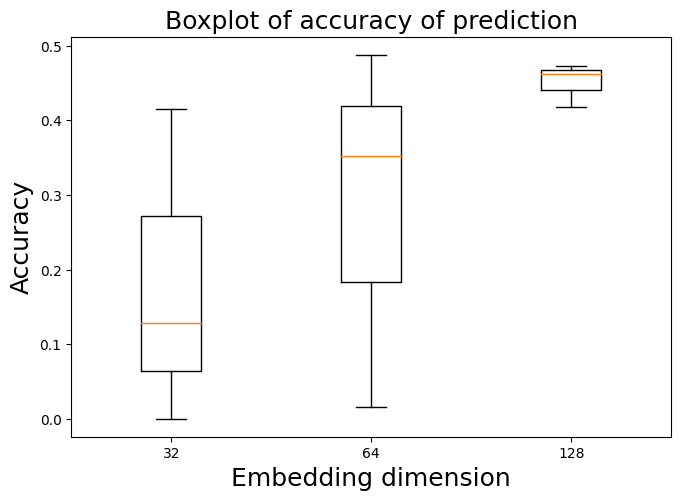

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_accs)
# ax.set_xticklabels(['32', '64', '128'])
# plt.title("Boxplot of accuracy of prediction", fontsize=18)
# plt.xlabel("Embedding dimension", fontsize=18)
# plt.ylabel("Accuracy", fontsize=18)
# plt.show()

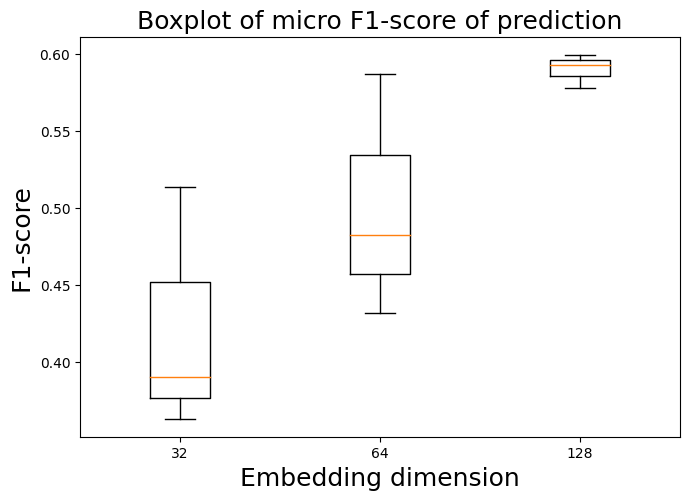

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_f1ms)
# ax.set_xticklabels(['32', '64', '128'])
# plt.title("Boxplot of micro F1-score of prediction", fontsize=18)
# plt.xlabel("Embedding dimension", fontsize=18)
# plt.ylabel("F1-score", fontsize=18)
# plt.show()

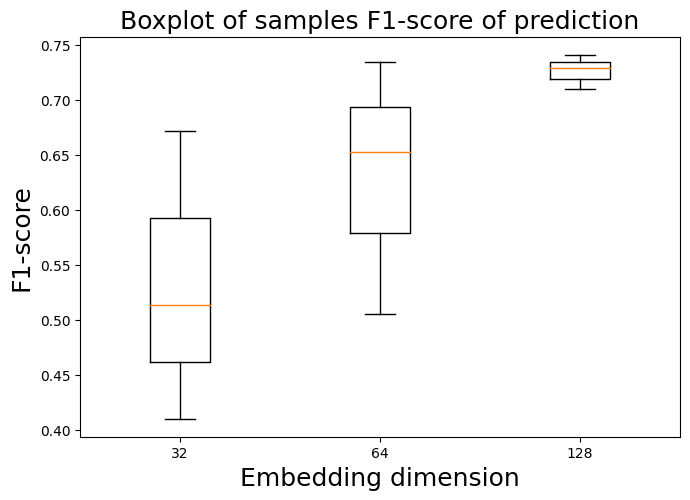

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_f1ss)
# ax.set_xticklabels(['32', '64', '128'])
# plt.title("Boxplot of samples F1-score of prediction", fontsize=18)
# plt.xlabel("Embedding dimension", fontsize=18)
# plt.ylabel("F1-score", fontsize=18)
# plt.show()

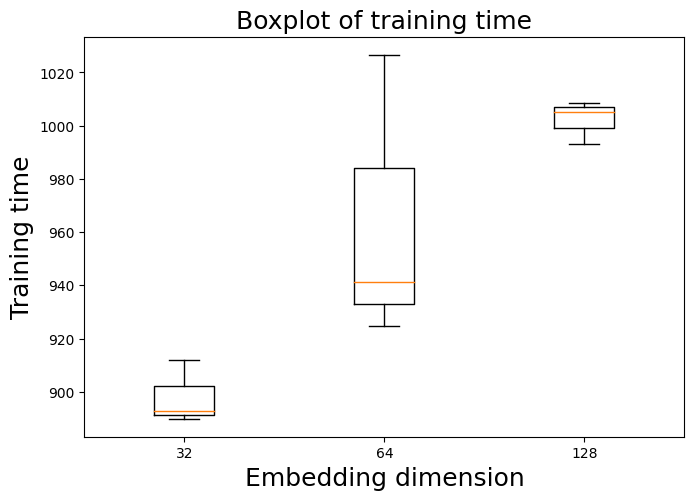

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(training_times)
# ax.set_xticklabels(['32', '64', '128'])
# plt.title("Boxplot of training time", fontsize=18)
# plt.xlabel("Embedding dimension", fontsize=18)
# plt.ylabel("Training time", fontsize=18)
# plt.show()

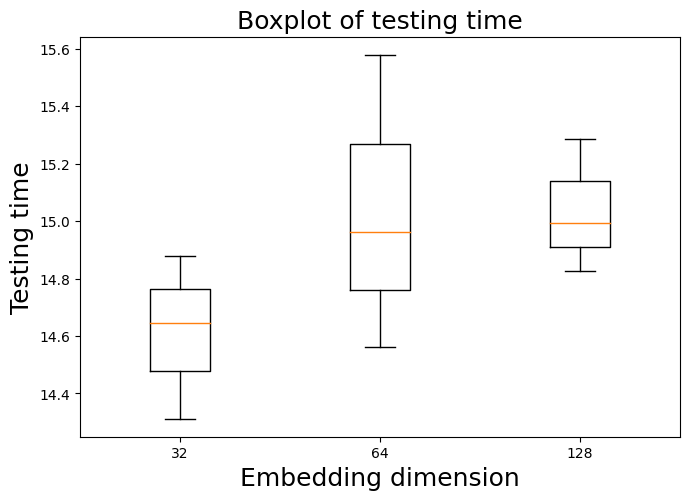

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(testing_times)
# ax.set_xticklabels(['32', '64', '128'])
# plt.title("Boxplot of testing time", fontsize=18)
# plt.xlabel("Embedding dimension", fontsize=18)
# plt.ylabel("Testing time", fontsize=18)
# plt.show()

## Learning rate

In [ ]:
# import time

# EMBEDDING_DIM = 128
# HIDDEN_DIM = 256

# def criterion(loss_func, outputs, targets):
#     losses = 0
#     for i, key in enumerate(outputs):
#         losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
#     return losses

# number_epochs = 20

# test_accs = []
# test_f1ms = []
# test_f1ss = []
# training_times = []
# testing_times = []

# for learningrate in [0.1, 0.01, 0.001]:

#   test_acc = []
#   test_f1m = []
#   test_f1s = []
#   training_time = []
#   testing_time = []

#   for iterator in range(3):

#     print("------STARTING MODEL "+ str(iterator)+" FOR LEARNING RATE VALUE "+str(learningrate)+"------")

#     # INITIALIZE MODEL

#     model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
#     loss_function = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learningrate)

#     # TRAIN MODEL

#     start_training = time.time()

#     for epoch in range(number_epochs):

#       loss_now = 0.0
#       correct = 0

#       for sentence,targets in train_loader:
          
#           sentence = sentence.to(device)
#           targets = targets.to(device)

#           temp_batch_size = sentence.shape[0]

#           model.train()
#           optimizer.zero_grad()               
#           class_pred = model(sentence)
#           loss = criterion(loss_function, class_pred, targets)
#           loss.backward()
#           optimizer.step()
#           loss_now += loss.item() * temp_batch_size
          
#           class_pred_tensor = None

#           for i, key in enumerate(class_pred.keys()):
#               if i==0:
#                   class_pred_tensor = class_pred[key]
#               else:
#                   all_entries = []
#                   for i in range(class_pred_tensor.shape[0]):
#                       l = class_pred_tensor[i].tolist()
#                       if isinstance(l, float):
#                           l = [l, class_pred[key][i].item()]
#                       else:
#                           l.append(class_pred[key][i].item())
#                       all_entries.append(l)
#                   class_pred_tensor = torch.tensor(all_entries)

#           pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
#           correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
        
#       print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

#     training_time_val = time.time() - start_training

#     # TEST MODEL

#     start_testing = time.time()

#     for i in range(1,20):
#       if i==12:
#         continue
#       exec('label'+str(i)+'_actual_class=[]')
#       exec('label'+str(i)+'_predicted_class=[]')

#     for sentence, targets in test_loader:
#         # Sentence to classify
#         sentence = sentence.to(device)
#         # Target class
#         target = targets.to(device)
#         target = target.view(-1)
#         # Predicted class
#         prob_pred = model(sentence)
#         class_pred_tensor = None
#         for i, key in enumerate(prob_pred.keys()):
#             if i==0:
#                 class_pred_tensor = prob_pred[key]
#             else:
#                 all_entries = []
#                 for i in range(class_pred_tensor.shape[0]):
#                     l = class_pred_tensor[i].tolist()
#                     if isinstance(l, float):
#                         l = [l, prob_pred[key][i].item()]
#                     else:
#                         l.append(prob_pred[key][i].item())
#                     all_entries.append(l)
#                 class_pred_tensor = torch.tensor(all_entries)
#         class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

#         for i in range(1,20):
#           corr=0
#           if i==12:
#             continue
#           if i>12:
#             corr=1
#           exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
#           exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
#           exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
#           exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

#     # CREATE PREDICTION LIST PER LABEL

#     predicted_labels = []
#     for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
#                           label2_predicted_class, 
#                           label3_predicted_class,
#                           label4_predicted_class,
#                           label5_predicted_class,
#                           label6_predicted_class,
#                           label7_predicted_class,
#                           label8_predicted_class,
#                           label9_predicted_class,
#                           label10_predicted_class,
#                           label11_predicted_class,
#                           label13_predicted_class,
#                           label14_predicted_class,
#                           label15_predicted_class,
#                           label16_predicted_class,
#                           label17_predicted_class,
#                           label18_predicted_class,
#                           label19_predicted_class):
#       predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

#     actual_labels = []
#     for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
#                           label2_actual_class, 
#                           label3_actual_class,
#                           label4_actual_class,
#                           label5_actual_class,
#                           label6_actual_class,
#                           label7_actual_class,
#                           label8_actual_class,
#                           label9_actual_class,
#                           label10_actual_class,
#                           label11_actual_class,
#                           label13_actual_class,
#                           label14_actual_class,
#                           label15_actual_class,
#                           label16_actual_class,
#                           label17_actual_class,
#                           label18_actual_class,
#                           label19_actual_class):
#       actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

#     testing_time_val = time.time() - start_testing

#     # CALCULATE PERFORMANCE METRICS

#     from sklearn.metrics import accuracy_score, f1_score

#     acc = accuracy_score(predicted_labels, actual_labels)
#     f1m = f1_score(predicted_labels, actual_labels,average='micro')
#     f1s = f1_score(predicted_labels, actual_labels,average='samples')

#     test_acc.append(acc)
#     test_f1m.append(f1m)
#     test_f1s.append(f1s)
#     training_time.append(training_time_val)
#     testing_time.append(testing_time_val)

#   print("STATS FOR LEARNING RATE VALUE "+str(learningrate))
#   print(test_acc)
#   print(test_f1m)
#   print(test_f1s)
#   print(training_time)
#   print(testing_time)
  
#   test_accs.append(test_acc)
#   test_f1ms.append(test_f1m)
#   test_f1ss.append(test_f1s)
#   training_times.append(training_time)
#   testing_times.append(testing_time)



------STARTING MODEL 0 FOR LEARNING RATE VALUE 0.1------
Epoch: 1, training loss: 961.5690, training accuracy: 0.00%
Epoch: 2, training loss: 961.5724, training accuracy: 0.00%
Epoch: 3, training loss: 961.5105, training accuracy: 0.00%
Epoch: 4, training loss: 961.5028, training accuracy: 0.00%
Epoch: 5, training loss: 961.5415, training accuracy: 0.00%
Epoch: 6, training loss: 961.5466, training accuracy: 0.00%
Epoch: 7, training loss: 961.5183, training accuracy: 0.00%
Epoch: 8, training loss: 961.5595, training accuracy: 0.00%
Epoch: 9, training loss: 961.5312, training accuracy: 0.00%
Epoch: 10, training loss: 961.5054, training accuracy: 0.00%
Epoch: 11, training loss: 961.5647, training accuracy: 0.00%
Epoch: 12, training loss: 961.5621, training accuracy: 0.00%
Epoch: 13, training loss: 961.5518, training accuracy: 0.00%
Epoch: 14, training loss: 961.5492, training accuracy: 0.00%
Epoch: 15, training loss: 961.5389, training accuracy: 0.00%
Epoch: 16, training loss: 961.5724, t

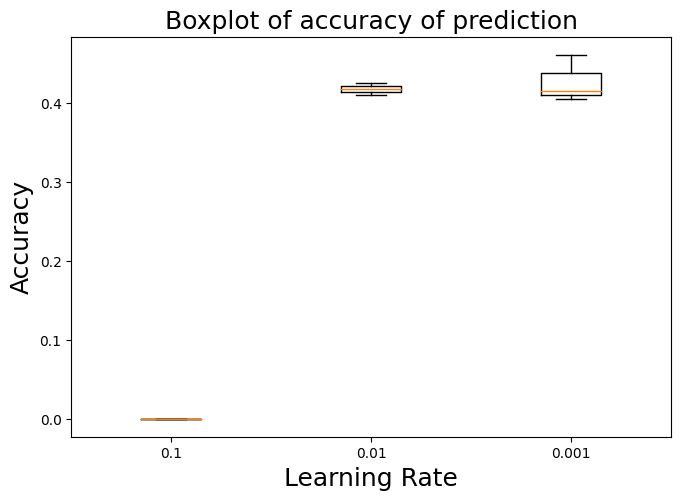

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_accs)
# ax.set_xticklabels(['0.1', '0.01', '0.001'])
# plt.title("Boxplot of accuracy of prediction", fontsize=18)
# plt.xlabel("Learning Rate", fontsize=18)
# plt.ylabel("Accuracy", fontsize=18)
# plt.show()

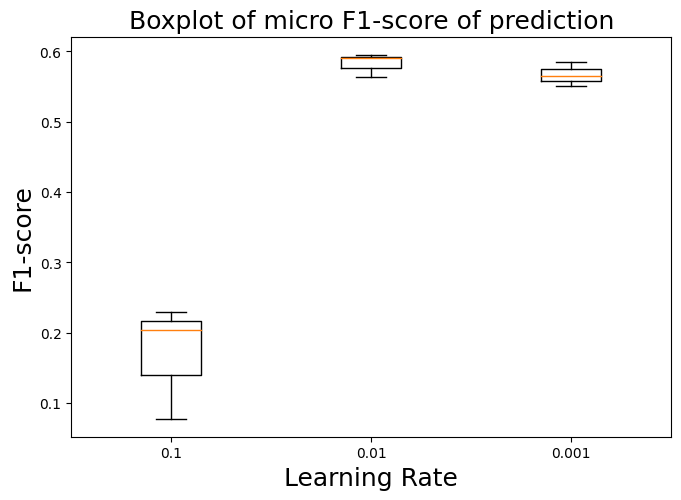

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_f1ms)
# ax.set_xticklabels(['0.1', '0.01', '0.001'])
# plt.title("Boxplot of micro F1-score of prediction", fontsize=18)
# plt.xlabel("Learning Rate", fontsize=18)
# plt.ylabel("F1-score", fontsize=18)
# plt.show()

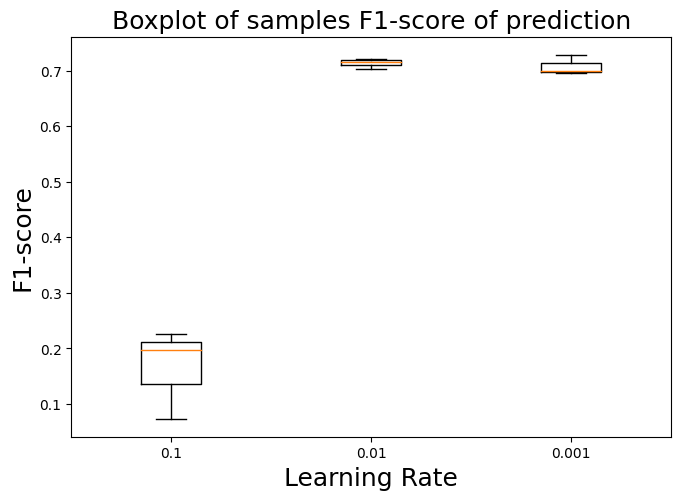

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_f1ss)
# ax.set_xticklabels(['0.1', '0.01', '0.001'])
# plt.title("Boxplot of samples F1-score of prediction", fontsize=18)
# plt.xlabel("Learning Rate", fontsize=18)
# plt.ylabel("F1-score", fontsize=18)
# plt.show()

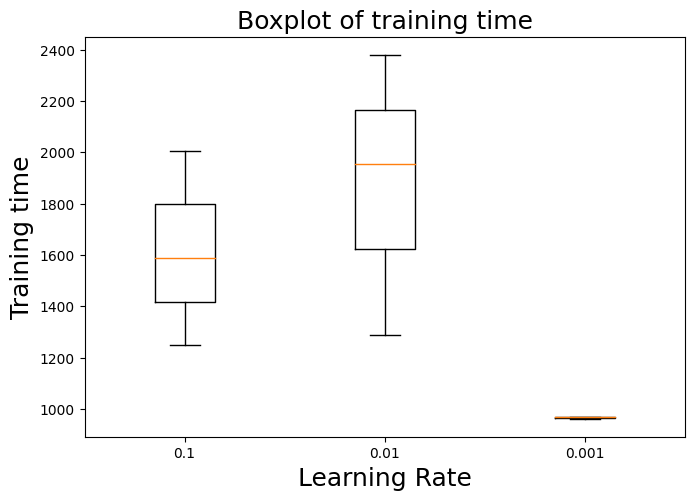

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(training_times)
# ax.set_xticklabels(['0.1', '0.01', '0.001'])
# plt.title("Boxplot of training time", fontsize=18)
# plt.xlabel("Learning Rate", fontsize=18)
# plt.ylabel("Training time", fontsize=18)
# plt.show()

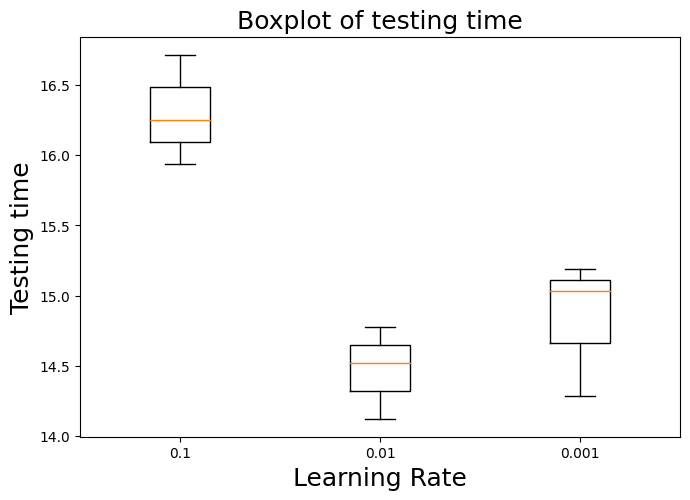

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(testing_times)
# ax.set_xticklabels(['0.1', '0.01', '0.001'])
# plt.title("Boxplot of testing time", fontsize=18)
# plt.xlabel("Learning Rate", fontsize=18)
# plt.ylabel("Testing time", fontsize=18)
# plt.show()

## Hidden cell state dimension

In [ ]:
# import time

# EMBEDDING_DIM = 128

# def criterion(loss_func, outputs, targets):
#     losses = 0
#     for i, key in enumerate(outputs):
#         losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
#     return losses

# number_epochs = 20

# test_accs = []
# test_f1ms = []
# test_f1ss = []
# training_times = []
# testing_times = []

# for hiddendim in [64, 128, 256]:

#   test_acc = []
#   test_f1m = []
#   test_f1s = []
#   training_time = []
#   testing_time = []

#   HIDDEN_DIM = hiddendim

#   for iterator in range(3):

#     print("------STARTING MODEL "+ str(iterator)+" FOR HIDDEN DIM VALUE "+str(hiddendim)+"------")

#     # INITIALIZE MODEL

#     model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
#     loss_function = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#     # TRAIN MODEL

#     start_training = time.time()

#     for epoch in range(number_epochs):

#       loss_now = 0.0
#       correct = 0

#       for sentence,targets in train_loader:
          
#           sentence = sentence.to(device)
#           targets = targets.to(device)

#           temp_batch_size = sentence.shape[0]

#           model.train()
#           optimizer.zero_grad()               
#           class_pred = model(sentence)
#           loss = criterion(loss_function, class_pred, targets)
#           loss.backward()
#           optimizer.step()
#           loss_now += loss.item() * temp_batch_size
          
#           class_pred_tensor = None

#           for i, key in enumerate(class_pred.keys()):
#               if i==0:
#                   class_pred_tensor = class_pred[key]
#               else:
#                   all_entries = []
#                   for i in range(class_pred_tensor.shape[0]):
#                       l = class_pred_tensor[i].tolist()
#                       if isinstance(l, float):
#                           l = [l, class_pred[key][i].item()]
#                       else:
#                           l.append(class_pred[key][i].item())
#                       all_entries.append(l)
#                   class_pred_tensor = torch.tensor(all_entries)

#           pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
#           correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
        
#       print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

#     training_time_val = time.time() - start_training

#     # TEST MODEL

#     start_testing = time.time()

#     for i in range(1,20):
#       if i==12:
#         continue
#       exec('label'+str(i)+'_actual_class=[]')
#       exec('label'+str(i)+'_predicted_class=[]')

#     for sentence, targets in test_loader:
#         # Sentence to classify
#         sentence = sentence.to(device)
#         # Target class
#         target = targets.to(device)
#         target = target.view(-1)
#         # Predicted class
#         prob_pred = model(sentence)
#         class_pred_tensor = None
#         for i, key in enumerate(prob_pred.keys()):
#             if i==0:
#                 class_pred_tensor = prob_pred[key]
#             else:
#                 all_entries = []
#                 for i in range(class_pred_tensor.shape[0]):
#                     l = class_pred_tensor[i].tolist()
#                     if isinstance(l, float):
#                         l = [l, prob_pred[key][i].item()]
#                     else:
#                         l.append(prob_pred[key][i].item())
#                     all_entries.append(l)
#                 class_pred_tensor = torch.tensor(all_entries)
#         class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

#         for i in range(1,20):
#           corr=0
#           if i==12:
#             continue
#           if i>12:
#             corr=1
#           exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
#           exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
#           exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
#           exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

#     # CREATE PREDICTION LIST PER LABEL

#     predicted_labels = []
#     for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
#                           label2_predicted_class, 
#                           label3_predicted_class,
#                           label4_predicted_class,
#                           label5_predicted_class,
#                           label6_predicted_class,
#                           label7_predicted_class,
#                           label8_predicted_class,
#                           label9_predicted_class,
#                           label10_predicted_class,
#                           label11_predicted_class,
#                           label13_predicted_class,
#                           label14_predicted_class,
#                           label15_predicted_class,
#                           label16_predicted_class,
#                           label17_predicted_class,
#                           label18_predicted_class,
#                           label19_predicted_class):
#       predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

#     actual_labels = []
#     for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
#                           label2_actual_class, 
#                           label3_actual_class,
#                           label4_actual_class,
#                           label5_actual_class,
#                           label6_actual_class,
#                           label7_actual_class,
#                           label8_actual_class,
#                           label9_actual_class,
#                           label10_actual_class,
#                           label11_actual_class,
#                           label13_actual_class,
#                           label14_actual_class,
#                           label15_actual_class,
#                           label16_actual_class,
#                           label17_actual_class,
#                           label18_actual_class,
#                           label19_actual_class):
#       actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

#     testing_time_val = time.time() - start_testing

#     # CALCULATE PERFORMANCE METRICS

#     from sklearn.metrics import accuracy_score, f1_score

#     acc = accuracy_score(predicted_labels, actual_labels)
#     f1m = f1_score(predicted_labels, actual_labels,average='micro')
#     f1s = f1_score(predicted_labels, actual_labels,average='samples')

#     test_acc.append(acc)
#     test_f1m.append(f1m)
#     test_f1s.append(f1s)
#     training_time.append(training_time_val)
#     testing_time.append(testing_time_val)
  
#   print("STATS FOR HIDDEN DIM VALUE "+str(hiddendim))
#   print(test_acc)
#   print(test_f1m)
#   print(test_f1s)
#   print(training_time)
#   print(testing_time)

#   test_accs.append(test_acc)
#   test_f1ms.append(test_f1m)
#   test_f1ss.append(test_f1s)
#   training_times.append(training_time)
#   testing_times.append(testing_time)



------STARTING MODEL 0 FOR HIDDEN DIM VALUE 64------
Epoch: 1, training loss: 961.5438, training accuracy: 0.00%
Epoch: 2, training loss: 947.9869, training accuracy: 0.00%
Epoch: 3, training loss: 928.7930, training accuracy: 0.00%
Epoch: 4, training loss: 926.7280, training accuracy: 0.00%
Epoch: 5, training loss: 924.4007, training accuracy: 0.01%
Epoch: 7, training loss: 920.2492, training accuracy: 0.03%
Epoch: 8, training loss: 917.8898, training accuracy: 0.03%
Epoch: 9, training loss: 914.6450, training accuracy: 0.03%
Epoch: 10, training loss: 910.7023, training accuracy: 0.03%
Epoch: 11, training loss: 910.0152, training accuracy: 0.03%
Epoch: 12, training loss: 908.5918, training accuracy: 0.03%
Epoch: 13, training loss: 907.2927, training accuracy: 0.03%
Epoch: 14, training loss: 906.9632, training accuracy: 0.05%
Epoch: 15, training loss: 906.4745, training accuracy: 0.05%
Epoch: 16, training loss: 905.8877, training accuracy: 0.11%
Epoch: 17, training loss: 904.5328, trai

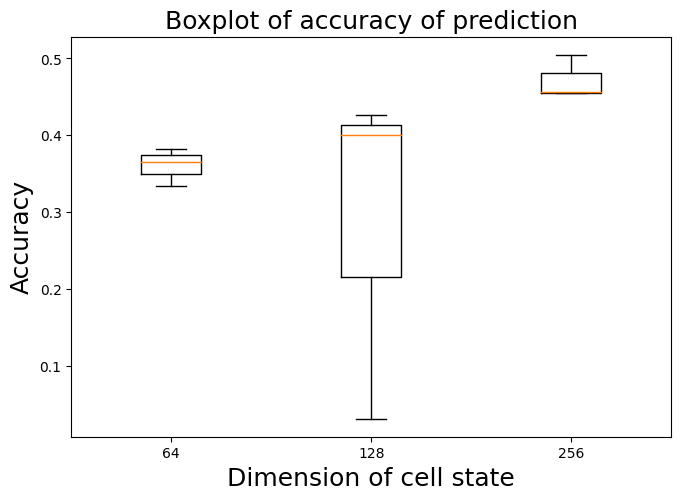

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_accs)
# ax.set_xticklabels(['64', '128', '256'])
# plt.title("Boxplot of accuracy of prediction", fontsize=18)
# plt.xlabel("Dimension of cell state", fontsize=18)
# plt.ylabel("Accuracy", fontsize=18)
# plt.show()

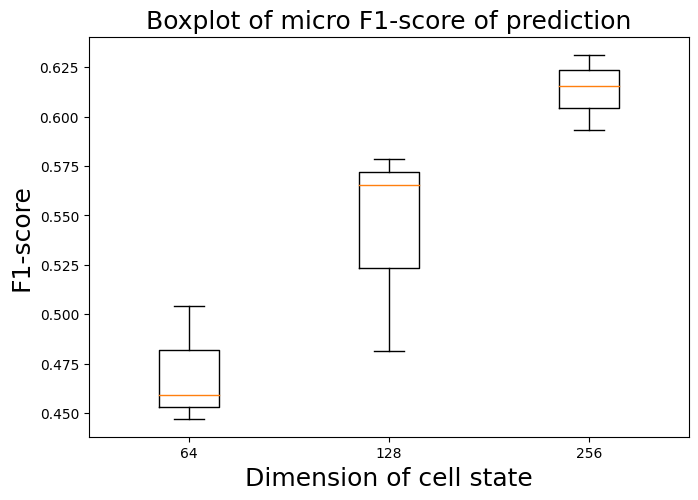

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_f1ms)
# ax.set_xticklabels(['64', '128', '256'])
# plt.title("Boxplot of micro F1-score of prediction", fontsize=18)
# plt.xlabel("Dimension of cell state", fontsize=18)
# plt.ylabel("F1-score", fontsize=18)
# plt.show()

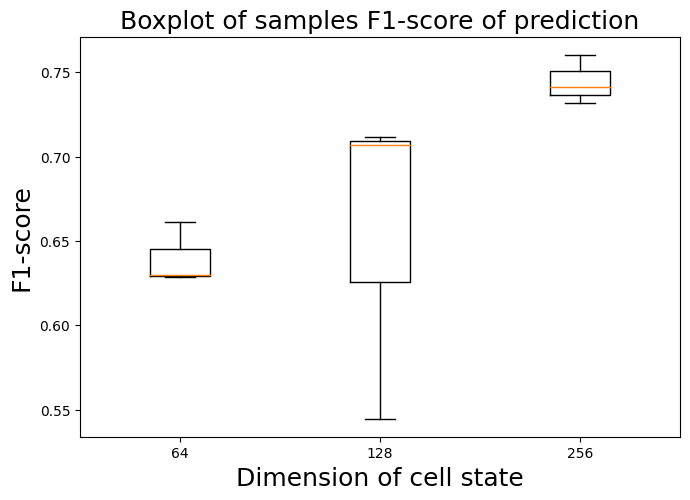

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(test_f1ss)
# ax.set_xticklabels(['64', '128', '256'])
# plt.title("Boxplot of samples F1-score of prediction", fontsize=18)
# plt.xlabel("Dimension of cell state", fontsize=18)
# plt.ylabel("F1-score", fontsize=18)
# plt.show()

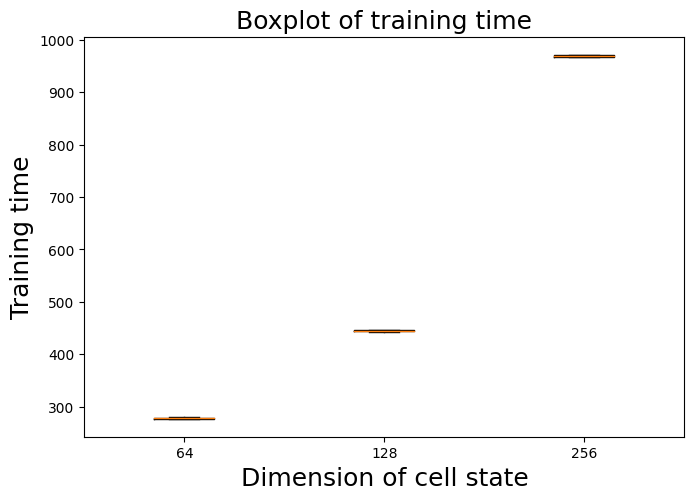

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(training_times)
# ax.set_xticklabels(['64', '128', '256'])
# plt.title("Boxplot of training time", fontsize=18)
# plt.xlabel("Dimension of cell state", fontsize=18)
# plt.ylabel("Training time", fontsize=18)
# plt.show()

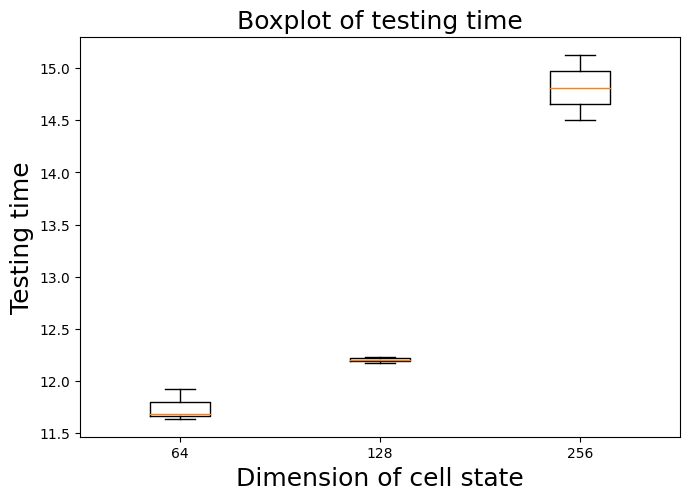

In [ ]:
# fig = plt.figure(figsize =(6, 4))
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(testing_times)
# ax.set_xticklabels(['64', '128', '256'])
# plt.title("Boxplot of testing time", fontsize=18)
# plt.xlabel("Dimension of cell state", fontsize=18)
# plt.ylabel("Testing time", fontsize=18)
# plt.show()


## Standard vs not removing stopwords vs not stemming

In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMClassifier, self).__init__()
        # Word embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=False)  
        # Linear layer
        self.lbl1 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl2 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl3 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl4 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl5 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl6 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl7 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl8 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl9 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl10 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl11 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl13 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl14 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl15 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl16 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl17 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl18 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )
        self.lbl19 = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_dim, out_features=1)
        )


    def forward(self, sentence):
        # Create the word embeddings
        embeds = self.word_embeddings(sentence)
        # Pass it through the LSTM
        lstm_out, _ = self.lstm(embeds)      
        # Add a linear layer
        class_pred_lbl1 = torch.sigmoid(torch.squeeze(self.lbl1(lstm_out), 2))[:,-1]
        class_pred_lbl2 = torch.sigmoid(torch.squeeze(self.lbl2(lstm_out), 2))[:,-1]
        class_pred_lbl3 = torch.sigmoid(torch.squeeze(self.lbl3(lstm_out), 2))[:,-1]
        class_pred_lbl4 = torch.sigmoid(torch.squeeze(self.lbl4(lstm_out), 2))[:,-1]
        class_pred_lbl5 = torch.sigmoid(torch.squeeze(self.lbl5(lstm_out), 2))[:,-1]
        class_pred_lbl6 = torch.sigmoid(torch.squeeze(self.lbl6(lstm_out), 2))[:,-1]
        class_pred_lbl7 = torch.sigmoid(torch.squeeze(self.lbl7(lstm_out), 2))[:,-1]
        class_pred_lbl8 = torch.sigmoid(torch.squeeze(self.lbl8(lstm_out), 2))[:,-1]
        class_pred_lbl9 = torch.sigmoid(torch.squeeze(self.lbl9(lstm_out), 2))[:,-1]
        class_pred_lbl10 = torch.sigmoid(torch.squeeze(self.lbl10(lstm_out), 2))[:,-1]
        class_pred_lbl11 = torch.sigmoid(torch.squeeze(self.lbl11(lstm_out), 2))[:,-1]
        class_pred_lbl13 = torch.sigmoid(torch.squeeze(self.lbl13(lstm_out), 2))[:,-1]
        class_pred_lbl14 = torch.sigmoid(torch.squeeze(self.lbl14(lstm_out), 2))[:,-1]
        class_pred_lbl15 = torch.sigmoid(torch.squeeze(self.lbl15(lstm_out), 2))[:,-1]
        class_pred_lbl16 = torch.sigmoid(torch.squeeze(self.lbl16(lstm_out), 2))[:,-1]
        class_pred_lbl17 = torch.sigmoid(torch.squeeze(self.lbl17(lstm_out), 2))[:,-1]
        class_pred_lbl18 = torch.sigmoid(torch.squeeze(self.lbl18(lstm_out), 2))[:,-1]
        class_pred_lbl19 = torch.sigmoid(torch.squeeze(self.lbl19(lstm_out), 2))[:,-1]
        return {'label1': class_pred_lbl1,
                'label2': class_pred_lbl2,
                'label3': class_pred_lbl3,
                'label4': class_pred_lbl4,
                'label5': class_pred_lbl5,
                'label6': class_pred_lbl6,
                'label7': class_pred_lbl7,
                'label8': class_pred_lbl8,
                'label9': class_pred_lbl9,
                'label10': class_pred_lbl10,
                'label11': class_pred_lbl11,
                'label13': class_pred_lbl13,
                'label14': class_pred_lbl14,
                'label15': class_pred_lbl15,
                'label16': class_pred_lbl16,
                'label17': class_pred_lbl17,
                'label18': class_pred_lbl18,
                'label19': class_pred_lbl19
                }



In [ ]:
import time
from sklearn.metrics import accuracy_score, f1_score

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

def criterion(loss_func, outputs, targets):
    losses = 0
    for i, key in enumerate(outputs):
        losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
    return losses

number_epochs = 20

test_acc = []
test_f1m = []
test_f1s = []
training_time = []
testing_time = []

for iterator in range(3):

  print("------STARTING MODEL "+ str(iterator)+" FOR STANDARD PREPROCESSING------")

  # INITIALIZE MODEL

  model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # TRAIN MODEL

  start_training = time.time()

  for epoch in range(number_epochs):

    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        model.train()
        optimizer.zero_grad()               
        class_pred = model(sentence)
        loss = criterion(loss_function, class_pred, targets)
        loss.backward()
        optimizer.step()
        loss_now += loss.item() * temp_batch_size
        
        class_pred_tensor = None

        for i, key in enumerate(class_pred.keys()):
            if i==0:
                class_pred_tensor = class_pred[key]
            else:
                all_entries = []
                for i in range(class_pred_tensor.shape[0]):
                    l = class_pred_tensor[i].tolist()
                    if isinstance(l, float):
                        l = [l, class_pred[key][i].item()]
                    else:
                        l.append(class_pred[key][i].item())
                    all_entries.append(l)
                class_pred_tensor = torch.tensor(all_entries)

        pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
        correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
      
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

  training_time_val = time.time() - start_training

  # TEST MODEL

  start_testing = time.time()

  for i in range(1,20):
    if i==12:
      continue
    exec('label'+str(i)+'_actual_class=[]')
    exec('label'+str(i)+'_predicted_class=[]')

  for sentence, targets in test_loader:
      # Sentence to classify
      sentence = sentence.to(device)
      # Target class
      target = targets.to(device)
      target = target.view(-1)
      # Predicted class
      prob_pred = model(sentence)
      class_pred_tensor = None
      for i, key in enumerate(prob_pred.keys()):
          if i==0:
              class_pred_tensor = prob_pred[key]
          else:
              all_entries = []
              for i in range(class_pred_tensor.shape[0]):
                  l = class_pred_tensor[i].tolist()
                  if isinstance(l, float):
                      l = [l, prob_pred[key][i].item()]
                  else:
                      l.append(prob_pred[key][i].item())
                  all_entries.append(l)
              class_pred_tensor = torch.tensor(all_entries)
      class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

      for i in range(1,20):
        corr=0
        if i==12:
          continue
        if i>12:
          corr=1
        exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
        exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
        exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
        exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

  # CREATE PREDICTION LIST PER LABEL

  predicted_labels = []
  for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
                        label2_predicted_class, 
                        label3_predicted_class,
                        label4_predicted_class,
                        label5_predicted_class,
                        label6_predicted_class,
                        label7_predicted_class,
                        label8_predicted_class,
                        label9_predicted_class,
                        label10_predicted_class,
                        label11_predicted_class,
                        label13_predicted_class,
                        label14_predicted_class,
                        label15_predicted_class,
                        label16_predicted_class,
                        label17_predicted_class,
                        label18_predicted_class,
                        label19_predicted_class):
    predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

  actual_labels = []
  for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
                        label2_actual_class, 
                        label3_actual_class,
                        label4_actual_class,
                        label5_actual_class,
                        label6_actual_class,
                        label7_actual_class,
                        label8_actual_class,
                        label9_actual_class,
                        label10_actual_class,
                        label11_actual_class,
                        label13_actual_class,
                        label14_actual_class,
                        label15_actual_class,
                        label16_actual_class,
                        label17_actual_class,
                        label18_actual_class,
                        label19_actual_class):
    actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

  testing_time_val = time.time() - start_testing

  # CALCULATE PERFORMANCE METRICS

  from sklearn.metrics import accuracy_score, f1_score

  acc = accuracy_score(predicted_labels, actual_labels)
  f1m = f1_score(predicted_labels, actual_labels,average='micro')
  f1s = f1_score(predicted_labels, actual_labels,average='samples')

  test_acc.append(acc)
  test_f1m.append(f1m)
  test_f1s.append(f1s)
  training_time.append(training_time_val)
  testing_time.append(testing_time_val)

print("STATS FOR STANDARD PREPROCESSING")
print(test_acc)
print(test_f1m)
print(test_f1s)
print(training_time)
print(testing_time)

acc_standard = test_acc
f1m_standard = test_f1m
f1s_standard = test_f1s
traint_standard = training_time
testt_standard = testing_time


------STARTING MODEL 0 FOR STANDARD PREPROCESSING------
Epoch: 1, training loss: 961.7484, training accuracy: 0.00%
Epoch: 2, training loss: 961.5985, training accuracy: 0.00%
Epoch: 3, training loss: 937.6181, training accuracy: 0.00%
Epoch: 4, training loss: 923.6242, training accuracy: 0.02%
Epoch: 5, training loss: 914.7242, training accuracy: 0.06%
Epoch: 6, training loss: 908.4250, training accuracy: 2.29%
Epoch: 7, training loss: 904.2347, training accuracy: 20.72%
Epoch: 8, training loss: 901.0304, training accuracy: 42.46%
Epoch: 9, training loss: 899.0313, training accuracy: 41.55%
Epoch: 10, training loss: 897.5973, training accuracy: 41.02%
Epoch: 11, training loss: 896.2874, training accuracy: 40.46%
Epoch: 12, training loss: 895.4417, training accuracy: 41.90%
Epoch: 13, training loss: 894.1661, training accuracy: 42.21%
Epoch: 14, training loss: 893.3787, training accuracy: 42.92%
Epoch: 15, training loss: 892.3042, training accuracy: 43.52%
Epoch: 16, training loss: 891

In [ ]:
df["Text2"] = df["Caption"].apply(clean_text)
#df["Text"] = df["Text"].apply(remove_stopwords)
df["Text2"] = df["Text2"].apply(stemming)
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label14,Label15,Label16,Label17,Label18,Label19,Text,NoText,PaddedNoText,Text2
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,0,0,woman swim suit hold parasol sunni day,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...",woman in swim suit hold parasol on sunni day
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,0,0,1,coupl men ride hors top green field,"[9, 10, 11, 12, 13, 14, 15]","[9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0, 0, 0, ...",a coupl of men ride hors on top of a green field
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,0,0,brave ride jungl eleph,"[16, 11, 17, 18]","[16, 11, 17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",they are brave for ride in the jungl on those ...
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,0,0,0,0,0,0,black silver clock tower intersect near tree,"[19, 20, 21, 22, 23, 24, 25]","[19, 20, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,...",a black and silver clock tower at an intersect...
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,0,0,train come stop track side,"[26, 27, 28, 29, 30]","[26, 27, 28, 29, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0...",a train come to a stop on the track out side


Text(0, 0.5, 'Number of examples')

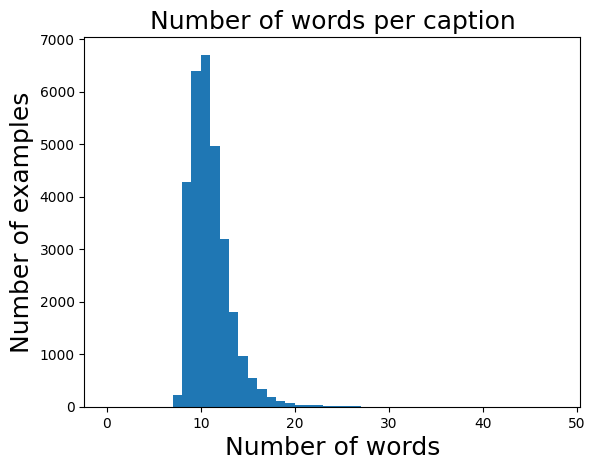

In [ ]:
lengths = []
for x in range(df.shape[0]):
    length = len(df["Text2"][x].split())
    lengths.append(length)

pd.DataFrame(lengths).hist(bins = np.arange(0,max(lengths)), grid=False)

plt.title("Number of words per caption", fontsize=18)
plt.xlabel("Number of words", fontsize=18)
plt.ylabel("Number of examples", fontsize=18)


In [ ]:
max(lengths)

49

In [ ]:
print(pd.DataFrame(lengths).value_counts())

10    6703
9     6392
11    4972
8     4282
12    3202
13    1800
14     974
15     556
16     343
7      220
17     192
18     108
19      70
20      37
21      37
22      30
23      21
24      18
25      11
26       7
28       4
29       4
31       2
32       2
37       2
27       1
30       1
33       1
36       1
38       1
39       1
49       1
dtype: int64


In [ ]:
words = []
for i in range(df["Text2"].shape[0]):
    new_sentence = [x for x in df["Text2"][i].split() if x not in words]
    for new_word in new_sentence:
        if new_word not in words:
            words.append(new_word)

In [ ]:
print(len(words))
print(words[:20])

4901
['woman', 'in', 'swim', 'suit', 'hold', 'parasol', 'on', 'sunni', 'day', 'a', 'coupl', 'of', 'men', 'ride', 'hors', 'top', 'green', 'field', 'they', 'are']


In [ ]:
words = ['--PAD--', '--OOV--']+words
print(len(words))
print(words[:20])

4903
['--PAD--', '--OOV--', 'woman', 'in', 'swim', 'suit', 'hold', 'parasol', 'on', 'sunni', 'day', 'a', 'coupl', 'of', 'men', 'ride', 'hors', 'top', 'green', 'field']


In [ ]:
# make a dictionary so that we can reference the index of each unique word
word_dict = {w: i for i, w in enumerate(words)}

In [ ]:
def word_to_no(text):
    word_li = text.split()
    no_li = [word_dict[x] if x in word_dict else word_dict['--OOV--'] for x in word_li]
    return no_li

In [ ]:
df["NoText2"] = df["Text2"].apply(lambda x: word_to_no(x))

In [ ]:
# Pad vectors and cut off at 20th element
max_length = max(lengths)
df["PaddedNoText2"] = df["NoText2"].apply(lambda x: list(x+[0]*(max_length-len(x)))[:26])
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label16,Label17,Label18,Label19,Text,NoText,PaddedNoText,Text2,NoText2,PaddedNoText2
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,woman swim suit hold parasol sunni day,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...",woman in swim suit hold parasol on sunni day,"[2, 3, 4, 5, 6, 7, 8, 9, 10]","[2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0, 0, 0, 0, 0,..."
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,1,coupl men ride hors top green field,"[9, 10, 11, 12, 13, 14, 15]","[9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0, 0, 0, ...",a coupl of men ride hors on top of a green field,"[11, 12, 13, 14, 15, 16, 8, 17, 13, 11, 18, 19]","[11, 12, 13, 14, 15, 16, 8, 17, 13, 11, 18, 19..."
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,brave ride jungl eleph,"[16, 11, 17, 18]","[16, 11, 17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",they are brave for ride in the jungl on those ...,"[20, 21, 22, 23, 15, 3, 24, 25, 8, 26, 27]","[20, 21, 22, 23, 15, 3, 24, 25, 8, 26, 27, 0, ..."
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,0,0,0,0,black silver clock tower intersect near tree,"[19, 20, 21, 22, 23, 24, 25]","[19, 20, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,...",a black and silver clock tower at an intersect...,"[11, 28, 29, 30, 31, 32, 33, 34, 35, 36, 11, 37]","[11, 28, 29, 30, 31, 32, 33, 34, 35, 36, 11, 3..."
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,train come stop track side,"[26, 27, 28, 29, 30]","[26, 27, 28, 29, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0...",a train come to a stop on the track out side,"[11, 38, 39, 40, 11, 41, 8, 24, 42, 43, 44]","[11, 38, 39, 40, 11, 41, 8, 24, 42, 43, 44, 0,..."


In [ ]:
train_sentences_encoded = []
for x in range(df.shape[0]):
    train_sentences_encoded.append(list(df["PaddedNoText2"][x]))
train_sentences_encoded = np.array(train_sentences_encoded)

In [ ]:
train_labels = []
for x in range(df.shape[0]):
    train_labels.append([df["Label1"][x], 
                         df["Label2"][x], 
                         df["Label3"][x],
                         df["Label4"][x],
                         df["Label5"][x],
                         df["Label6"][x],
                         df["Label7"][x],
                         df["Label8"][x],
                         df["Label9"][x],
                         df["Label10"][x],
                         df["Label11"][x],
                         df["Label13"][x],
                         df["Label14"][x],
                         df["Label15"][x],
                         df["Label16"][x],
                         df["Label17"][x],
                         df["Label18"][x],
                         df["Label19"][x]
                         ])
train_labels = np.array(train_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_sentences_encoded, 
                                                    train_labels, 
                                                    test_size=0.1, # 10% test, 90% train
                                                    random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if gpu_info.find('failed') >= 0:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = 'cpu'

In [ ]:
import torch
import torch.nn as nn
# Transform numpy arrays into tensor
x_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
x_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

In [ ]:
from torch.utils.data import TensorDataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_data, shuffle=True)

In [ ]:
import time
from sklearn.metrics import accuracy_score, f1_score

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

def criterion(loss_func, outputs, targets):
    losses = 0
    for i, key in enumerate(outputs):
        losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
    return losses

number_epochs = 20

test_acc = []
test_f1m = []
test_f1s = []
training_time = []
testing_time = []

for iterator in range(3):

  print("------STARTING MODEL "+ str(iterator)+" FOR NOT REMOVING STOPWORDS------")

  # INITIALIZE MODEL

  model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # TRAIN MODEL

  start_training = time.time()

  for epoch in range(number_epochs):

    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        model.train()
        optimizer.zero_grad()               
        class_pred = model(sentence)
        loss = criterion(loss_function, class_pred, targets)
        loss.backward()
        optimizer.step()
        loss_now += loss.item() * temp_batch_size
        
        class_pred_tensor = None

        for i, key in enumerate(class_pred.keys()):
            if i==0:
                class_pred_tensor = class_pred[key]
            else:
                all_entries = []
                for i in range(class_pred_tensor.shape[0]):
                    l = class_pred_tensor[i].tolist()
                    if isinstance(l, float):
                        l = [l, class_pred[key][i].item()]
                    else:
                        l.append(class_pred[key][i].item())
                    all_entries.append(l)
                class_pred_tensor = torch.tensor(all_entries)

        pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
        correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
      
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

  training_time_val = time.time() - start_training

  # TEST MODEL

  start_testing = time.time()

  for i in range(1,20):
    if i==12:
      continue
    exec('label'+str(i)+'_actual_class=[]')
    exec('label'+str(i)+'_predicted_class=[]')

  for sentence, targets in test_loader:
      # Sentence to classify
      sentence = sentence.to(device)
      # Target class
      target = targets.to(device)
      target = target.view(-1)
      # Predicted class
      prob_pred = model(sentence)
      class_pred_tensor = None
      for i, key in enumerate(prob_pred.keys()):
          if i==0:
              class_pred_tensor = prob_pred[key]
          else:
              all_entries = []
              for i in range(class_pred_tensor.shape[0]):
                  l = class_pred_tensor[i].tolist()
                  if isinstance(l, float):
                      l = [l, prob_pred[key][i].item()]
                  else:
                      l.append(prob_pred[key][i].item())
                  all_entries.append(l)
              class_pred_tensor = torch.tensor(all_entries)
      class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

      for i in range(1,20):
        corr=0
        if i==12:
          continue
        if i>12:
          corr=1
        exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
        exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
        exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
        exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

  # CREATE PREDICTION LIST PER LABEL

  predicted_labels = []
  for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
                        label2_predicted_class, 
                        label3_predicted_class,
                        label4_predicted_class,
                        label5_predicted_class,
                        label6_predicted_class,
                        label7_predicted_class,
                        label8_predicted_class,
                        label9_predicted_class,
                        label10_predicted_class,
                        label11_predicted_class,
                        label13_predicted_class,
                        label14_predicted_class,
                        label15_predicted_class,
                        label16_predicted_class,
                        label17_predicted_class,
                        label18_predicted_class,
                        label19_predicted_class):
    predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

  actual_labels = []
  for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
                        label2_actual_class, 
                        label3_actual_class,
                        label4_actual_class,
                        label5_actual_class,
                        label6_actual_class,
                        label7_actual_class,
                        label8_actual_class,
                        label9_actual_class,
                        label10_actual_class,
                        label11_actual_class,
                        label13_actual_class,
                        label14_actual_class,
                        label15_actual_class,
                        label16_actual_class,
                        label17_actual_class,
                        label18_actual_class,
                        label19_actual_class):
    actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

  testing_time_val = time.time() - start_testing

  # CALCULATE PERFORMANCE METRICS

  acc = accuracy_score(predicted_labels, actual_labels)
  f1m = f1_score(predicted_labels, actual_labels,average='micro')
  f1s = f1_score(predicted_labels, actual_labels,average='samples')

  test_acc.append(acc)
  test_f1m.append(f1m)
  test_f1s.append(f1s)
  training_time.append(training_time_val)
  testing_time.append(testing_time_val)

print("STATS FOR NOT REMOVING STOPWORDS")
print(test_acc)
print(test_f1m)
print(test_f1s)
print(training_time)
print(testing_time)

acc_with_stopwords = test_acc
f1m_with_stopwords = test_f1m
f1s_with_stopwords = test_f1s
traint_with_stopwords = training_time
testt_with_stopwords = testing_time


------STARTING MODEL 0 FOR NOT REMOVING STOPWORDS------
Epoch: 1, training loss: 961.6672, training accuracy: 0.00%
Epoch: 2, training loss: 961.6369, training accuracy: 0.00%
Epoch: 3, training loss: 952.5712, training accuracy: 0.00%
Epoch: 4, training loss: 920.0575, training accuracy: 25.53%
Epoch: 5, training loss: 912.5062, training accuracy: 37.75%
Epoch: 6, training loss: 907.9555, training accuracy: 41.45%
Epoch: 7, training loss: 905.6525, training accuracy: 42.85%
Epoch: 8, training loss: 903.3120, training accuracy: 42.58%
Epoch: 9, training loss: 900.6410, training accuracy: 42.07%
Epoch: 10, training loss: 899.0543, training accuracy: 41.80%
Epoch: 11, training loss: 897.6298, training accuracy: 42.42%
Epoch: 12, training loss: 896.9931, training accuracy: 43.51%
Epoch: 13, training loss: 896.3388, training accuracy: 43.37%
Epoch: 14, training loss: 895.1016, training accuracy: 42.33%
Epoch: 15, training loss: 893.9380, training accuracy: 42.59%
Epoch: 16, training loss: 

In [ ]:
acc_with_stopwords = [0.381, 0.4076666666666667, 0.028666666666666667]
f1m_with_stopwords = [0.5669360122297445, 0.5734347571679345, 0.49534985331752074]
f1s_with_stopwords = [0.6890254153254153, 0.7069307951307953, 0.5497717856217856]
traint_with_stopwords = [1611.2211298942566, 1305.6797842979431, 1247.9709963798523]
testt_with_stopwords = [17.655126333236694, 16.262556314468384, 15.388444423675537]

In [ ]:
df["Text3"] = df["Caption"].apply(clean_text)
df["Text3"] = df["Text3"].apply(remove_stopwords)
#df["Text"] = df["Text"].apply(stemming)
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label14,Label15,Label16,Label17,Label18,Label19,Text,NoText,PaddedNoText,Text3
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,0,0,woman swim suit hold parasol sunni day,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...",woman swim suit holding parasol sunny day
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,0,0,1,coupl men ride hors top green field,"[9, 10, 11, 12, 13, 14, 15]","[9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0, 0, 0, ...",couple men riding horses top green field
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,0,0,brave ride jungl eleph,"[16, 11, 17, 18]","[16, 11, 17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",brave riding jungle elephants
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,0,0,0,0,0,0,black silver clock tower intersect near tree,"[19, 20, 21, 22, 23, 24, 25]","[19, 20, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,...",black silver clock tower intersection near tree
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,0,0,train come stop track side,"[26, 27, 28, 29, 30]","[26, 27, 28, 29, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0...",train coming stop tracks side


In [ ]:
lengths = []
for x in range(df.shape[0]):
    length = len(df["Text3"][x].split())
    lengths.append(length)

Text(0, 0.5, 'Number of examples')

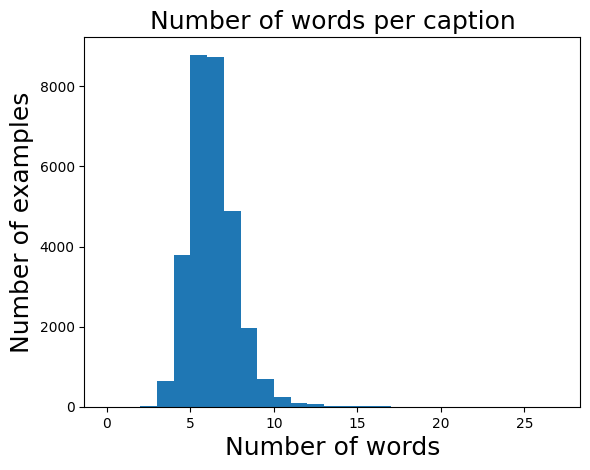

In [ ]:
pd.DataFrame(lengths).hist(bins = np.arange(0,max(lengths)), grid=False)

plt.title("Number of words per caption", fontsize=18)
plt.xlabel("Number of words", fontsize=18)
plt.ylabel("Number of examples", fontsize=18)

In [ ]:
print(max(lengths))

print(pd.DataFrame(lengths).value_counts())

28
5     8788
6     8734
7     4883
4     3782
8     1967
9      690
3      654
10     244
11     102
12      63
13      27
2       17
14      15
15       8
16       8
17       3
18       3
19       2
23       1
24       1
1        1
22       1
20       1
28       1
dtype: int64


In [ ]:
words = []
for i in range(df["Text3"].shape[0]):
    new_sentence = [x for x in df["Text3"][i].split() if x not in words]
    for new_word in new_sentence:
        if new_word not in words:
            words.append(new_word)

In [ ]:
print(len(words))
print(words[:20])

6905
['woman', 'swim', 'suit', 'holding', 'parasol', 'sunny', 'day', 'couple', 'men', 'riding', 'horses', 'top', 'green', 'field', 'brave', 'jungle', 'elephants', 'black', 'silver', 'clock']


In [ ]:
words = ['--PAD--', '--OOV--']+words
print(len(words))
print(words[:20])


6907
['--PAD--', '--OOV--', 'woman', 'swim', 'suit', 'holding', 'parasol', 'sunny', 'day', 'couple', 'men', 'riding', 'horses', 'top', 'green', 'field', 'brave', 'jungle', 'elephants', 'black']


In [ ]:
# make a dictionary so that we can reference the index of each unique word
word_dict = {w: i for i, w in enumerate(words)}

In [ ]:
def word_to_no(text):
    word_li = text.split()
    no_li = [word_dict[x] if x in word_dict else word_dict['--OOV--'] for x in word_li]
    return no_li


In [ ]:
df["NoText3"] = df["Text3"].apply(lambda x: word_to_no(x))

In [ ]:
# Pad vectors and cut off at 20th element
max_length = max(lengths)
df["PaddedNoText3"] = df["NoText3"].apply(lambda x: list(x+[0]*(max_length-len(x)))[:26])
df.head()

,ImageID,ID,Labels,NoLabels,Caption,Label1,Label2,Label3,Label4,Label5,...,Label16,Label17,Label18,Label19,Text,NoText,PaddedNoText,Text3,NoText3,PaddedNoText3
0,0.jpg,0,1,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,...,0,0,0,0,woman swim suit hold parasol sunni day,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...",woman swim suit holding parasol sunny day,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1.jpg,1,1 19,2,A couple of men riding horses on top of a gree...,1,0,0,0,0,...,0,0,0,1,coupl men ride hors top green field,"[9, 10, 11, 12, 13, 14, 15]","[9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0, 0, 0, ...",couple men riding horses top green field,"[9, 10, 11, 12, 13, 14, 15]","[9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0, 0, 0, ..."
2,2.jpg,2,1,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,...,0,0,0,0,brave ride jungl eleph,"[16, 11, 17, 18]","[16, 11, 17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",brave riding jungle elephants,"[16, 11, 17, 18]","[16, 11, 17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3.jpg,3,8 3 13,3,a black and silver clock tower at an intersect...,0,0,1,0,0,...,0,0,0,0,black silver clock tower intersect near tree,"[19, 20, 21, 22, 23, 24, 25]","[19, 20, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,...",black silver clock tower intersection near tree,"[19, 20, 21, 22, 23, 24, 25]","[19, 20, 21, 22, 23, 24, 25, 0, 0, 0, 0, 0, 0,..."
4,4.jpg,4,8 3 7,3,A train coming to a stop on the tracks out side.,0,0,1,0,0,...,0,0,0,0,train come stop track side,"[26, 27, 28, 29, 30]","[26, 27, 28, 29, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0...",train coming stop tracks side,"[26, 27, 28, 29, 30]","[26, 27, 28, 29, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [ ]:
train_sentences_encoded = []
for x in range(df.shape[0]):
    train_sentences_encoded.append(list(df["PaddedNoText3"][x]))
train_sentences_encoded = np.array(train_sentences_encoded)


train_labels = []
for x in range(df.shape[0]):
    train_labels.append([df["Label1"][x], 
                         df["Label2"][x], 
                         df["Label3"][x],
                         df["Label4"][x],
                         df["Label5"][x],
                         df["Label6"][x],
                         df["Label7"][x],
                         df["Label8"][x],
                         df["Label9"][x],
                         df["Label10"][x],
                         df["Label11"][x],
                         df["Label13"][x],
                         df["Label14"][x],
                         df["Label15"][x],
                         df["Label16"][x],
                         df["Label17"][x],
                         df["Label18"][x],
                         df["Label19"][x]
                         ])
train_labels = np.array(train_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_sentences_encoded, 
                                                    train_labels, 
                                                    test_size=0.1, # 10% test, 90% train
                                                    random_state=42)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if gpu_info.find('failed') >= 0:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = 'cpu'

# Transform numpy arrays into tensor
x_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
x_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

from torch.utils.data import TensorDataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_data, shuffle=True)

In [ ]:
import time
from sklearn.metrics import accuracy_score, f1_score

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

def criterion(loss_func, outputs, targets):
    losses = 0
    for i, key in enumerate(outputs):
        losses += loss_func(outputs[key].type(torch.DoubleTensor), targets[:,i].type(torch.DoubleTensor).to(device))
    return losses

number_epochs = 20

test_acc = []
test_f1m = []
test_f1s = []
training_time = []
testing_time = []

for iterator in range(3):

  print("------STARTING MODEL "+ str(iterator)+" FOR NOT STEMMING------")

  # INITIALIZE MODEL

  model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_dict)).to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # TRAIN MODEL

  start_training = time.time()

  for epoch in range(number_epochs):

    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        model.train()
        optimizer.zero_grad()               
        class_pred = model(sentence)
        loss = criterion(loss_function, class_pred, targets)
        loss.backward()
        optimizer.step()
        loss_now += loss.item() * temp_batch_size
        
        class_pred_tensor = None

        for i, key in enumerate(class_pred.keys()):
            if i==0:
                class_pred_tensor = class_pred[key]
            else:
                all_entries = []
                for i in range(class_pred_tensor.shape[0]):
                    l = class_pred_tensor[i].tolist()
                    if isinstance(l, float):
                        l = [l, class_pred[key][i].item()]
                    else:
                        l.append(class_pred[key][i].item())
                    all_entries.append(l)
                class_pred_tensor = torch.tensor(all_entries)

        pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))
        correct += accuracy_score(pred.detach().numpy(), targets.detach().numpy())*temp_batch_size
      
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

  training_time_val = time.time() - start_training

  # TEST MODEL

  start_testing = time.time()

  for i in range(1,20):
    if i==12:
      continue
    exec('label'+str(i)+'_actual_class=[]')
    exec('label'+str(i)+'_predicted_class=[]')

  for sentence, targets in test_loader:
      # Sentence to classify
      sentence = sentence.to(device)
      # Target class
      target = targets.to(device)
      target = target.view(-1)
      # Predicted class
      prob_pred = model(sentence)
      class_pred_tensor = None
      for i, key in enumerate(prob_pred.keys()):
          if i==0:
              class_pred_tensor = prob_pred[key]
          else:
              all_entries = []
              for i in range(class_pred_tensor.shape[0]):
                  l = class_pred_tensor[i].tolist()
                  if isinstance(l, float):
                      l = [l, prob_pred[key][i].item()]
                  else:
                      l.append(prob_pred[key][i].item())
                  all_entries.append(l)
              class_pred_tensor = torch.tensor(all_entries)
      class_pred = class_pred_tensor.detach().apply_(lambda x: int(1) if x>0.5 else int(0))

      for i in range(1,20):
        corr=0
        if i==12:
          continue
        if i>12:
          corr=1
        exec('label'+str(i)+'_true = int(target['+str(i-1-corr)+'])')
        exec('label'+str(i)+'_pred = int(class_pred[0]['+str(i-1-corr)+'])')
        exec('label'+str(i)+'_actual_class.append(label'+str(i)+'_true)')
        exec('label'+str(i)+'_predicted_class.append(label'+str(i)+'_pred)')

  # CREATE PREDICTION LIST PER LABEL

  predicted_labels = []
  for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_predicted_class, 
                        label2_predicted_class, 
                        label3_predicted_class,
                        label4_predicted_class,
                        label5_predicted_class,
                        label6_predicted_class,
                        label7_predicted_class,
                        label8_predicted_class,
                        label9_predicted_class,
                        label10_predicted_class,
                        label11_predicted_class,
                        label13_predicted_class,
                        label14_predicted_class,
                        label15_predicted_class,
                        label16_predicted_class,
                        label17_predicted_class,
                        label18_predicted_class,
                        label19_predicted_class):
    predicted_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18, lab19])

  actual_labels = []
  for lab1, lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19 in zip(label1_actual_class, 
                        label2_actual_class, 
                        label3_actual_class,
                        label4_actual_class,
                        label5_actual_class,
                        label6_actual_class,
                        label7_actual_class,
                        label8_actual_class,
                        label9_actual_class,
                        label10_actual_class,
                        label11_actual_class,
                        label13_actual_class,
                        label14_actual_class,
                        label15_actual_class,
                        label16_actual_class,
                        label17_actual_class,
                        label18_actual_class,
                        label19_actual_class):
    actual_labels.append([lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9,lab10,lab11,lab13,lab14,lab15,lab16,lan17,lab18,lab19])

  testing_time_val = time.time() - start_testing

  # CALCULATE PERFORMANCE METRICS

  acc = accuracy_score(predicted_labels, actual_labels)
  f1m = f1_score(predicted_labels, actual_labels,average='micro')
  f1s = f1_score(predicted_labels, actual_labels,average='samples')

  test_acc.append(acc)
  test_f1m.append(f1m)
  test_f1s.append(f1s)
  training_time.append(training_time_val)
  testing_time.append(testing_time_val)

print("STATS FOR NOT STEMMING")
print(test_acc)
print(test_f1m)
print(test_f1s)
print(training_time)
print(testing_time)

acc_without_stemming = test_acc
f1m_without_stemming = test_f1m
f1s_without_stemming = test_f1s
traint_without_stemming = training_time
testt_without_stemming = testing_time


------STARTING MODEL 0 FOR NOT STEMMING------
Epoch: 1, training loss: 961.6738, training accuracy: 0.00%
Epoch: 2, training loss: 961.6234, training accuracy: 0.00%
Epoch: 3, training loss: 961.6724, training accuracy: 0.00%
Epoch: 4, training loss: 961.5987, training accuracy: 0.00%
Epoch: 5, training loss: 961.6108, training accuracy: 0.00%
Epoch: 6, training loss: 961.5944, training accuracy: 0.00%
Epoch: 7, training loss: 961.5858, training accuracy: 0.00%
Epoch: 8, training loss: 961.5463, training accuracy: 0.00%
Epoch: 9, training loss: 961.5850, training accuracy: 0.00%
Epoch: 10, training loss: 961.5655, training accuracy: 0.00%
Epoch: 11, training loss: 952.8892, training accuracy: 0.00%
Epoch: 12, training loss: 921.2305, training accuracy: 0.89%
Epoch: 13, training loss: 906.6929, training accuracy: 5.88%
Epoch: 14, training loss: 902.6147, training accuracy: 32.88%
Epoch: 15, training loss: 899.3746, training accuracy: 38.93%
Epoch: 16, training loss: 897.3974, training a

In [ ]:
test_accs = [acc_standard, acc_with_stopwords, acc_without_stemming]
test_f1ms = [f1m_standard, f1m_with_stopwords, f1m_without_stemming]
test_f1ss = [f1s_standard, f1s_with_stopwords, f1s_without_stemming]
training_times = [traint_standard, traint_with_stopwords, traint_without_stemming]
testing_times = [testt_standard, testt_with_stopwords, testt_without_stemming]

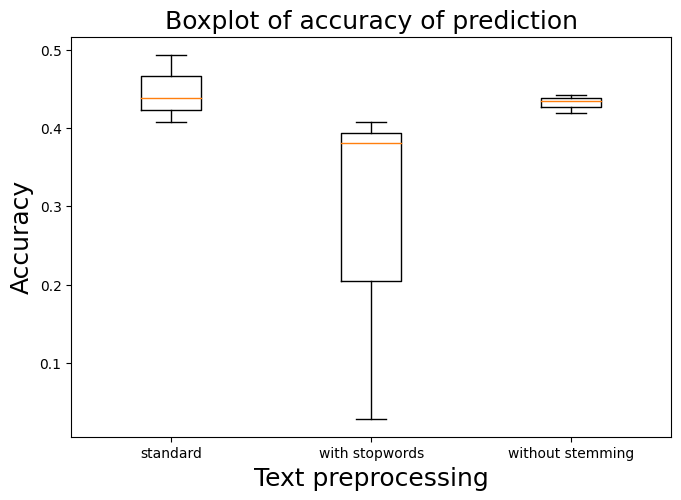

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_accs)
ax.set_xticklabels(['standard','with stopwords','without stemming'])
plt.title("Boxplot of accuracy of prediction", fontsize=18)
plt.xlabel("Text preprocessing", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.show()

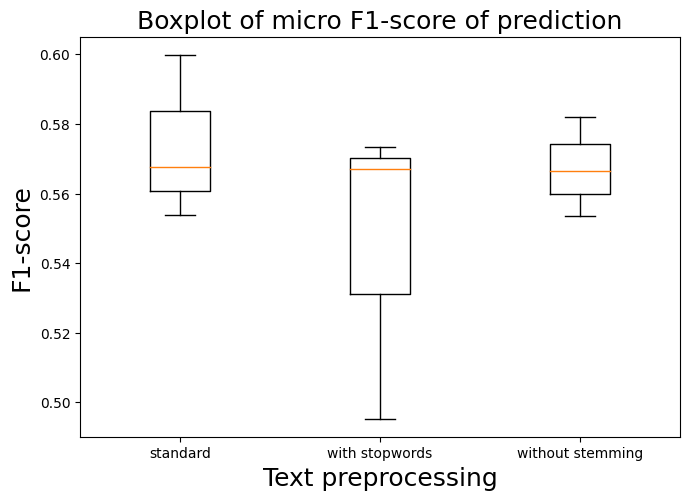

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_f1ms)
ax.set_xticklabels(['standard','with stopwords','without stemming'])
plt.title("Boxplot of micro F1-score of prediction", fontsize=18)
plt.xlabel("Text preprocessing", fontsize=18)
plt.ylabel("F1-score", fontsize=18)
plt.show()

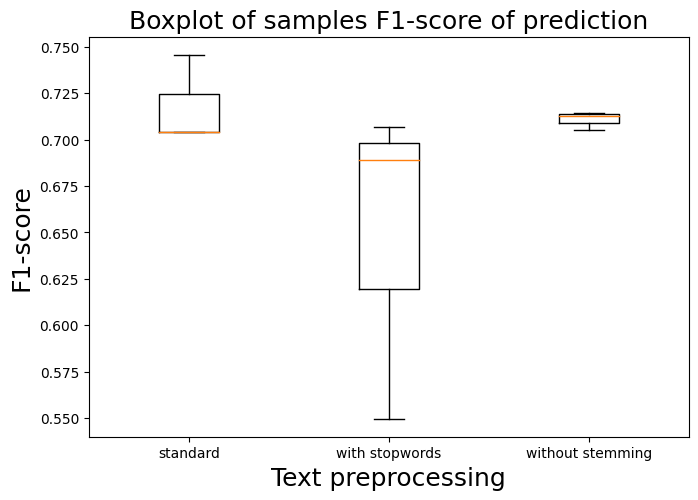

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(test_f1ss)
ax.set_xticklabels(['standard','with stopwords','without stemming'])
plt.title("Boxplot of samples F1-score of prediction", fontsize=18)
plt.xlabel("Text preprocessing", fontsize=18)
plt.ylabel("F1-score", fontsize=18)
plt.show()

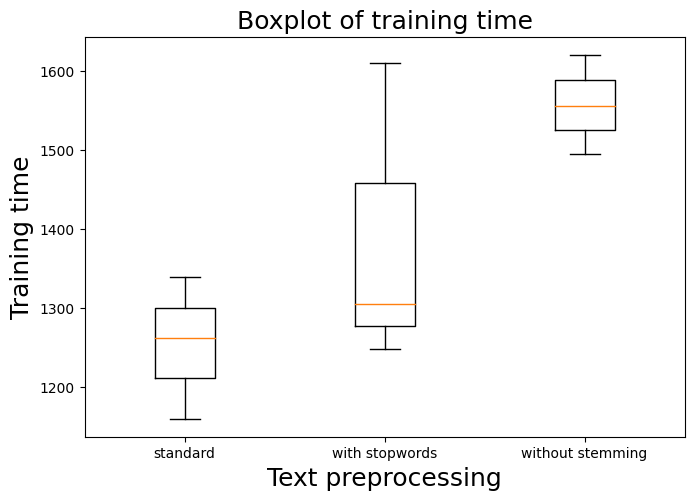

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(training_times)
ax.set_xticklabels(['standard','with stopwords','without stemming'])
plt.title("Boxplot of training time", fontsize=18)
plt.xlabel("Text preprocessing", fontsize=18)
plt.ylabel("Training time", fontsize=18)
plt.show()

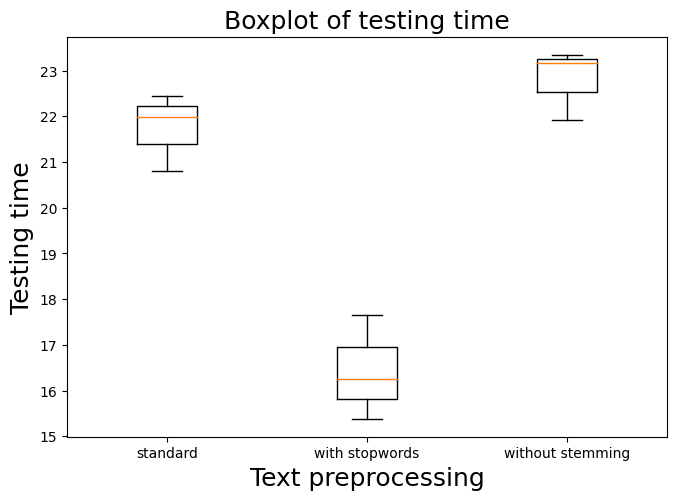

In [ ]:
fig = plt.figure(figsize =(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(testing_times)
ax.set_xticklabels(['standard','with stopwords','without stemming'])
plt.title("Boxplot of testing time", fontsize=18)
plt.xlabel("Text preprocessing", fontsize=18)
plt.ylabel("Testing time", fontsize=18)
plt.show()